# 0. Import libs

In [1]:
# define logging and working directory
from ProjectRoot import change_wd_to_project_root
change_wd_to_project_root()
from src.utils.Notebook_imports import *
import random
from collections import Counter
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 30})
import pandas as pd
import numpy as np
import os

from ipywidgets import interact
import ipywidgets as widgets
from IPython.core.display import display, HTML
%matplotlib inline
%reload_ext autoreload
%autoreload 2

search for root_dir and set working directory
Working directory set to: /mnt/ssd/git/dynamic-cmr-models


## 0.1 Link to medical definition of the cardiac function

[source](https://next.amboss.com/de/article/xL0E-g)

Systole
1.) Anspannungsphase

    Hauptfunktion: Ventrikel kontrahieren sich
    Ablauf
        Alle Klappen sind geschlossen und die Ventrikel sind mit Blut gefüllt
        Isovolumetrische Kontraktion des Arbeitsmyokards 

    Druckanstieg in den Ventrikeln, bis der Druck in der Aorta bzw. dem Truncus pulmonalis überschritten ist
    Passive Öffnung der Taschenklappen (Pulmonal- und Aortenklappe) → Beginn der Austreibungsphase

Status des linken Ventrikels

    Druck: Anstieg von ca. 8 mmHg auf ca. 80 mmHg 

Volumen: Gleichbleibend ca. 150 mL (isovolumetrische Anspannung)
2.) Austreibungsphase

    Hauptfunktion: Blut wird aus Ventrikeln in Kreislauf und Lunge gepumpt
    Ablauf
        Blut strömt aus den Ventrikeln in den Truncus pulmonalis bzw. die Aorta (Großteil bereits zu Beginn der Austreibungsphase)
        Weitere Kontraktion des Myokards (beginnend am distalen Septum und der Herzspitze)
        Wanddicke der Ventrikel ↑ und Innendurchmesser der Ventrikel ↓
        Druck in den Ventrikeln ↑ (Laplace-Gesetz) → Blutvolumen ↓ im Ventrikel
        Druck ↓ langsam im Ventrikel (bis unter den Druck der Aorta bzw. Truncus pulmonalis)
        Schluss der Taschenklappen → Beginn der Entspannungsphase
    Status des linken Ventrikels
        Druck: Anstieg von ca. 80 mmHg auf ca. 120 mmHg, danach Absinken 

Volumen: Austreibung von ca. 90 mL Schlagvolumen (150 mL → 60 mL)
Diastole
3.) Entspannungsphase

    Hauptfunktion: Ventrikel entspannen sich
    Ablauf
        Alle Herzklappen sind geschlossen (Volumen bleibt konstant)
        Weitere Entspannung des Myokards (Druck ↓ in den Ventrikeln)
        Isovolumetrische Entspannung
        Ventrikeldruck fällt unter den Druck in den Vorhöfen
        Segelklappen öffnen sich → Beginn der Füllungsphase
    Status des linken Ventrikels
        Druck: Absinken auf ca. 10 mmHg 

Volumen: Gleichbleibend ca. 60 mL (isovolumetrische Entspannung)
4.) Füllungsphase

    Hauptfunktion: Ventrikel füllen sich erneut mit Blut
    Ablauf
        Die Ventilebene hebt sich und "stülpt" sich über die Blutsäule in den Vorhöfen (Ventilebenenmechanismus)
        Am Ende der Diastole kontrahieren die Vorhöfe kurz
        Druck im Ventrikel übersteigt den Druck der Vorhöfe
        Schluss Segelklappen → Beginn der Anspannungsphase
    Status des linken Ventrikels
        Druck: ca. 8 mmHg 

Volumen: Füllung mit ca. 90 mL (60 mL → 150 mL)

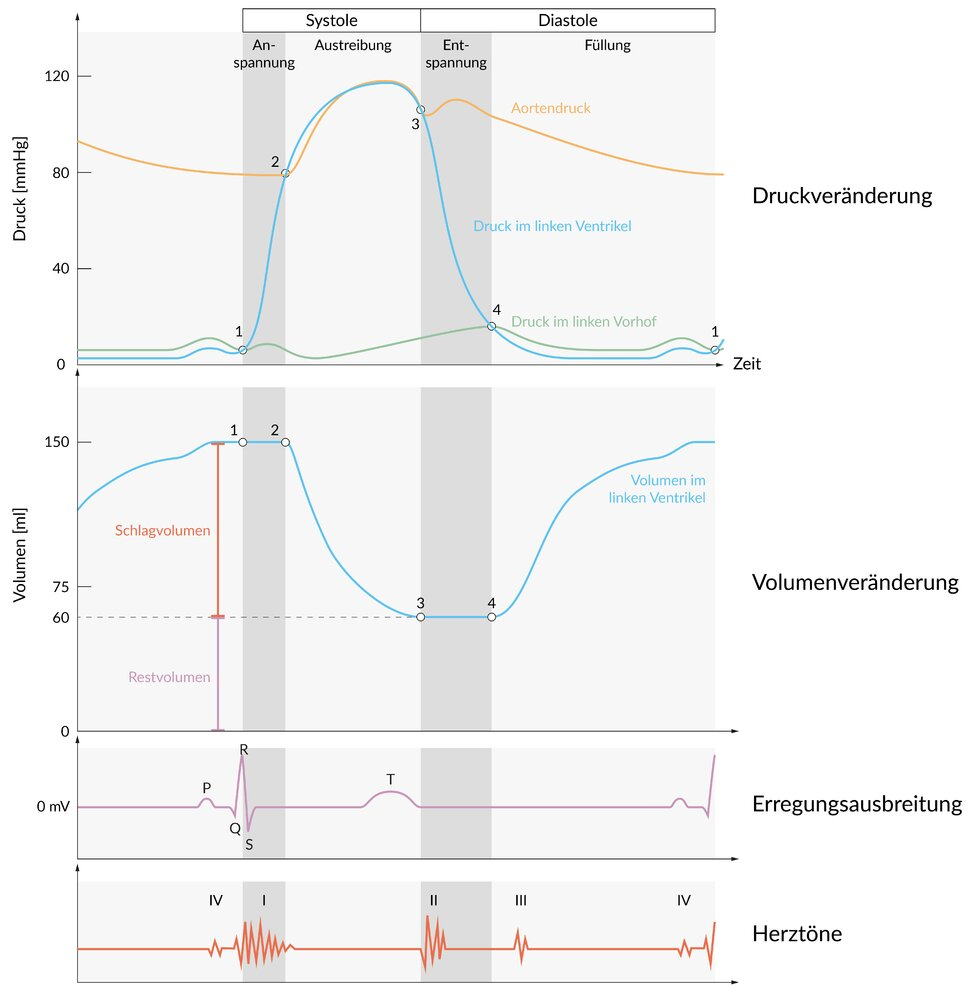

In [2]:
from IPython import display as disp
disp.Image("https://media-de.amboss.com/media/thumbs/big_5f22e89d3edf1.jpg")

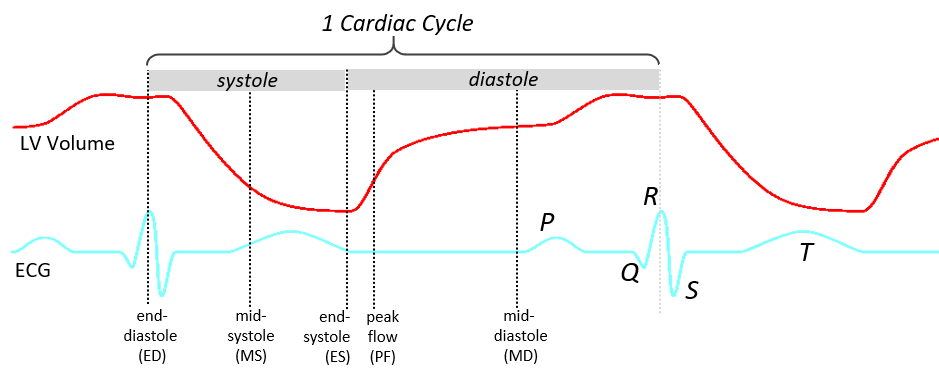

In [3]:
# mapping between the 5 defined cardiac phases and the lv volume curve
disp.Image("notebooks/Dataset/Wiggers_Diagram_21.png")

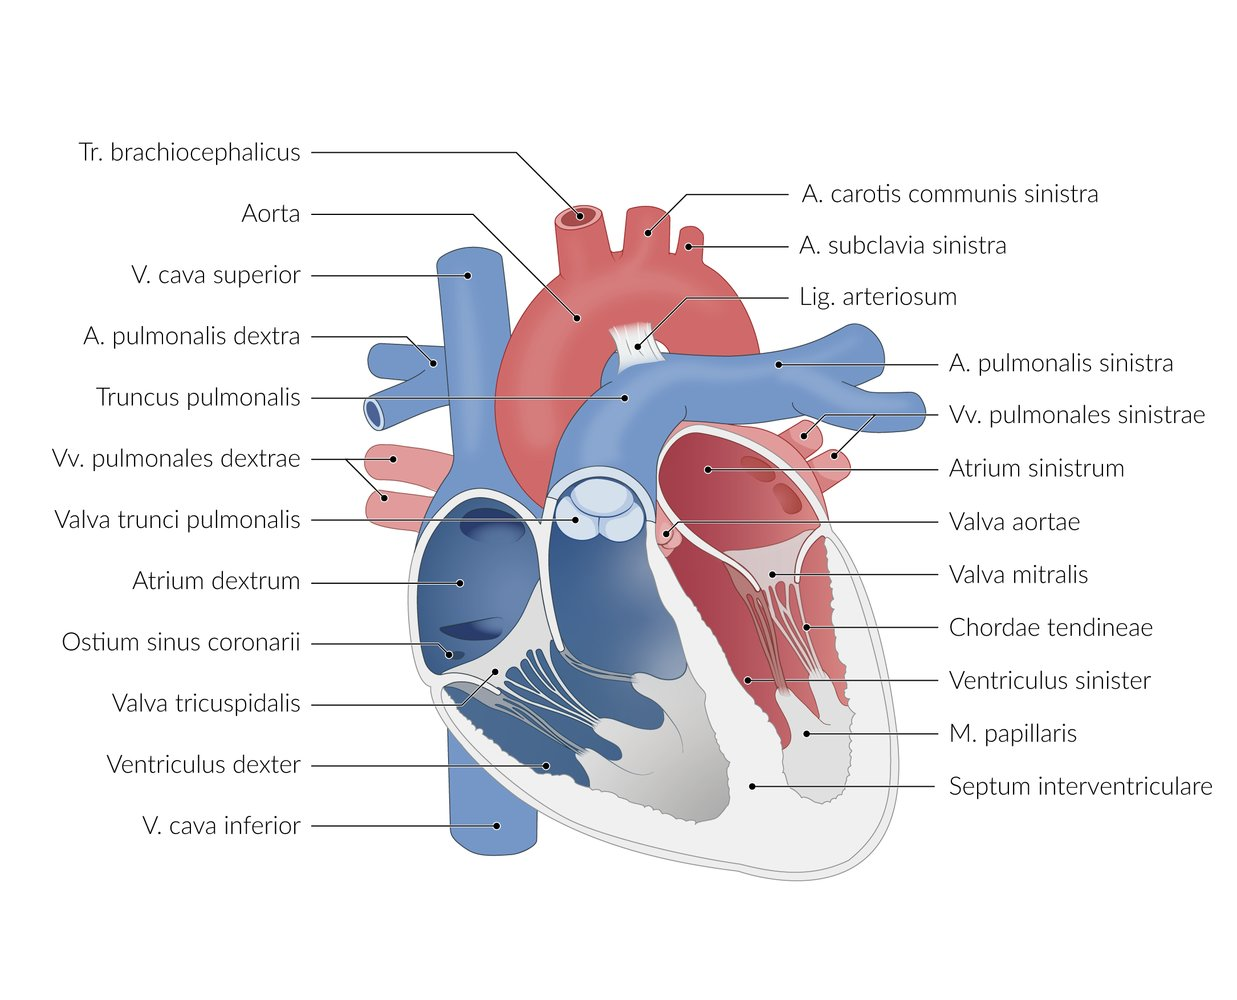

In [4]:
disp.Image("https://media-de.amboss.com/media/thumbs/big_5e147f74d36fe.jpg")

# 1. Load phase-vector and gt/pred from a project

In [5]:
from ipyfilechooser import FileChooser
vects_chooser = FileChooser(os.path.join(os.getcwd(),'/mnt/ssd/git/dynamic-cmr-models/exp/phasereg_v3/acdc/'), '')
display(vects_chooser)

FileChooser(path='/mnt/ssd/git/dynamic-cmr-models/exp/phasereg_v3/acdc', filename='', title='HTML(value='', la…

In [47]:
# load the vectors
pathstovectnpy = sorted(glob.glob(os.path.join(vects_chooser.selected, '*vects*.npy')))
print(pathstovectnpy)
nda_vects = np.concatenate([np.load(path_) for path_ in pathstovectnpy],axis=0)
print(nda_vects.shape)

['/mnt/ssd/git/dynamic-cmr-models/exp/phasereg_v3/acdc/augment/acdc_phaseloss05_lstm5_noTaug/2022-01-27_19_54/moved/vects_f0.npy', '/mnt/ssd/git/dynamic-cmr-models/exp/phasereg_v3/acdc/augment/acdc_phaseloss05_lstm5_noTaug/2022-01-27_19_54/moved/vects_f1.npy', '/mnt/ssd/git/dynamic-cmr-models/exp/phasereg_v3/acdc/augment/acdc_phaseloss05_lstm5_noTaug/2022-01-27_19_54/moved/vects_f2.npy', '/mnt/ssd/git/dynamic-cmr-models/exp/phasereg_v3/acdc/augment/acdc_phaseloss05_lstm5_noTaug/2022-01-27_19_54/moved/vects_f3.npy']
(99, 40, 16, 64, 64, 3)


In [48]:
# load the phase gt and pred
pred_path = vects_chooser.selected.replace('moved', 'pred')
pathtsophasenpy = sorted(glob.glob(os.path.join(pred_path, '*gtpred*.npy')))
print(pathtsophasenpy)
nda_phase = np.concatenate([np.load(path_) for path_ in pathtsophasenpy],axis=1)
print(nda_phase.shape)
gt_, pred_ = np.split(nda_phase, axis=0,indices_or_sections=2)
print(gt_.shape)
gt= gt_[0,:,0]
pred = pred_[0,:,0]
print(gt.shape)
gt_len = gt_[0,:,1]

['/mnt/ssd/git/dynamic-cmr-models/exp/phasereg_v3/acdc/augment/acdc_phaseloss05_lstm5_noTaug/2022-01-27_19_54/pred/gtpred_fold0.npy', '/mnt/ssd/git/dynamic-cmr-models/exp/phasereg_v3/acdc/augment/acdc_phaseloss05_lstm5_noTaug/2022-01-27_19_54/pred/gtpred_fold1.npy', '/mnt/ssd/git/dynamic-cmr-models/exp/phasereg_v3/acdc/augment/acdc_phaseloss05_lstm5_noTaug/2022-01-27_19_54/pred/gtpred_fold2.npy', '/mnt/ssd/git/dynamic-cmr-models/exp/phasereg_v3/acdc/augment/acdc_phaseloss05_lstm5_noTaug/2022-01-27_19_54/pred/gtpred_fold3.npy']
(2, 99, 2, 40, 5)
(1, 99, 2, 40, 5)
(99, 40, 5)


In [49]:
# load some moved examples for easier understanding of the dimensions
pathtomoved = sorted(glob.glob(os.path.join(vects_chooser.selected, '*moved*.npy')))
print(len(pathtomoved))
mov = np.load(pathtomoved[0])
print(mov.shape) # patient,time,spatial-z,y,x,channel, e.g.: 69,40,16,64,64,1

4
(25, 40, 16, 64, 64, 1)


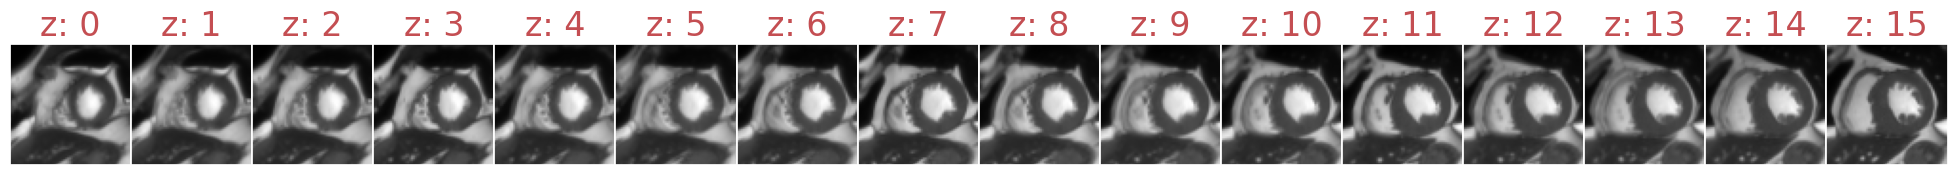

In [50]:
# plot one timestep of one patient = one 3D volume from apex to base
from src.visualization.Visualize import show_2D_or_3D
temp = mov[5,0,...,0]
_ = show_2D_or_3D(temp)

In [51]:
temp.shape

(16, 64, 64)

In [52]:
# compute some measures along the time
from skimage.metrics import structural_similarity as ssim
import tensorflow as tf
print(ssim(temp[0],temp[1]))
tf.image.ssim(temp[0:1][...,None],temp[1:2][...,None],max_val=1)

0.8601454373274818


<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.8335629], dtype=float32)>

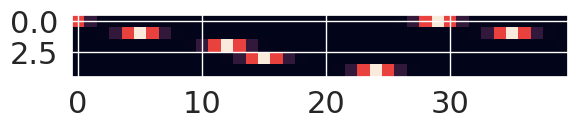

In [53]:
plt.imshow(gt[0].T)

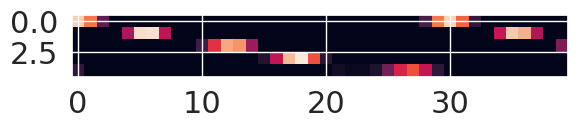

In [54]:
plt.imshow(pred[0].T)

# 2. Import / define some helper functions

In [31]:
import tensorflow as tf
import sys
# returns a matrix with the indicies as values, similar to np.indicies
def get_idxs_tf(x):
    return tf.cast(
        tf.reshape(tf.where(tf.ones((x[0], x[1], x[2]))), (x[0], x[1], x[2], 3)),
        tf.float32)


# returns a matrix with vectors pointing to the center
def get_centers_tf(x):
    return tf.cast(
        tf.tile(tf.convert_to_tensor([x[0] // 2, x[1] // 2, x[2] // 2])[tf.newaxis, tf.newaxis, tf.newaxis, ...],
                (x[0], x[1], x[2], 1)), tf.float32)

def get_angle_tf(a, b):
    # this should work for batches of n-dimensional vectors
    # α = arccos[(a · b) / (|a| * |b|)]
    # |v| = √(x² + y² + z²)
    """
    in 3D space
    If vectors a = [xa, ya, za], b = [xb, yb, zb], then:
    α = arccos[(xa * xb + ya * yb + za * zb) / (√(xa2 + ya2 + za2) * √(xb2 + yb2 + zb2))]
    """
    # import math as m
    # pi = tf.constant(m.pi)
    b = tf.cast(b, dtype=a.dtype)
    inner = tf.einsum('...i,...i->...', a, b)
    norms = tf.norm(a, ord='euclidean', axis=-1) * tf.norm(b, ord='euclidean', axis=-1)  # [...,None]
    cos = inner / (norms + sys.float_info.epsilon)
    # rad = tf.math.acos(tf.clip_by_value(cos, -1.0, 1.0))
    # rad2deg conversion
    # deg = rad * (180.0/pi)
    return cos[..., tf.newaxis]

dim = [16,64,64]
idx = get_idxs_tf(dim)
c = get_centers_tf(dim)
#print('centers: ',c.dtype)
centers = c - idx
centers_tensor = centers[tf.newaxis, ...]
flow2direction_lambda = tf.keras.layers.Lambda(
            lambda x: get_angle_tf(x, centers_tensor), name='flow2direction')


# 3. Align the direction and magnitude by ED Phase and resample to a fix length

In [55]:
# align norm an direction by the cardiac phase ED
# resample all 1D feature vectors to the same length
# this should help to validate the pre-defined rules, and if both together explains the cardiac phases
import scipy.interpolate
from scipy.interpolate import interp1d
norms = []
dirs= []
xval = np.linspace(0,1,40)

for i,n in enumerate(nda_vects[:]):
    cardiac_cycle_length = int(gt_len[i,:,0].sum())
    ind = np.argmax(gt[i][:cardiac_cycle_length],axis=0)
    dir_axis=0
    gt_ed = ind[0]
    #assert cardiac_cycle_length>=gt_ed
    temp = n[:cardiac_cycle_length]
    
    
    dim = temp.shape[1:-1]
    #print(dim)
    idx = get_idxs_tf(dim)
    c = get_centers_tf(dim)
    #print('centers: ',c.dtype)
    centers = c - idx
    centers_tensor = centers[tf.newaxis, ...]
    flow2direction_lambda = tf.keras.layers.Lambda(
            lambda x: get_angle_tf(x[...,dir_axis:], centers_tensor[...,dir_axis:]), name='flow2direction')
    
    directions = flow2direction_lambda(temp)[...,0]
    directions = np.mean(directions,axis=(1,2,3))
    directions = np.roll(directions, -1*gt_ed)
    # interpolate to unique length
    f = interp1d(np.linspace(0,1,directions.shape[0]), directions, kind='linear')
    directions = f(xval)
    norm_nda = np.linalg.norm(temp, axis=-1).mean(axis=(1,2,3))
    
    if cardiac_cycle_length<=gt_ed:
        print(gt_ed)
        print(cardiac_cycle_length)
        fig, ax = plt.subplots(figsize=(25,5))
        _ = plt.plot(norm_nda);plt.show()
    norm_nda = np.roll(norm_nda, -1*gt_ed)
    
    # interpolate to unique length
    f = interp1d(np.linspace(0,1,norm_nda.shape[0]), norm_nda, kind='linear')
    norm_nda = f(xval)
    norms.append(norm_nda)
    dirs.append(directions)

In [56]:
# get the mean values
norms = np.stack(norms, axis=0)
dirs = np.stack(dirs, axis=0)
norms_m = [norms.mean(axis=0)]
dirs_m=[dirs.mean(axis=0)]

## 3.1 Plot the mean +/- SD direction & magnitude of all patients over time

Each patient-specific frame2frame deformation is:
- Croped by cardiac cycle length
- Starts at GT ED phase (np.roll)
- Linearly interpolated to a unique length of 40 Frames

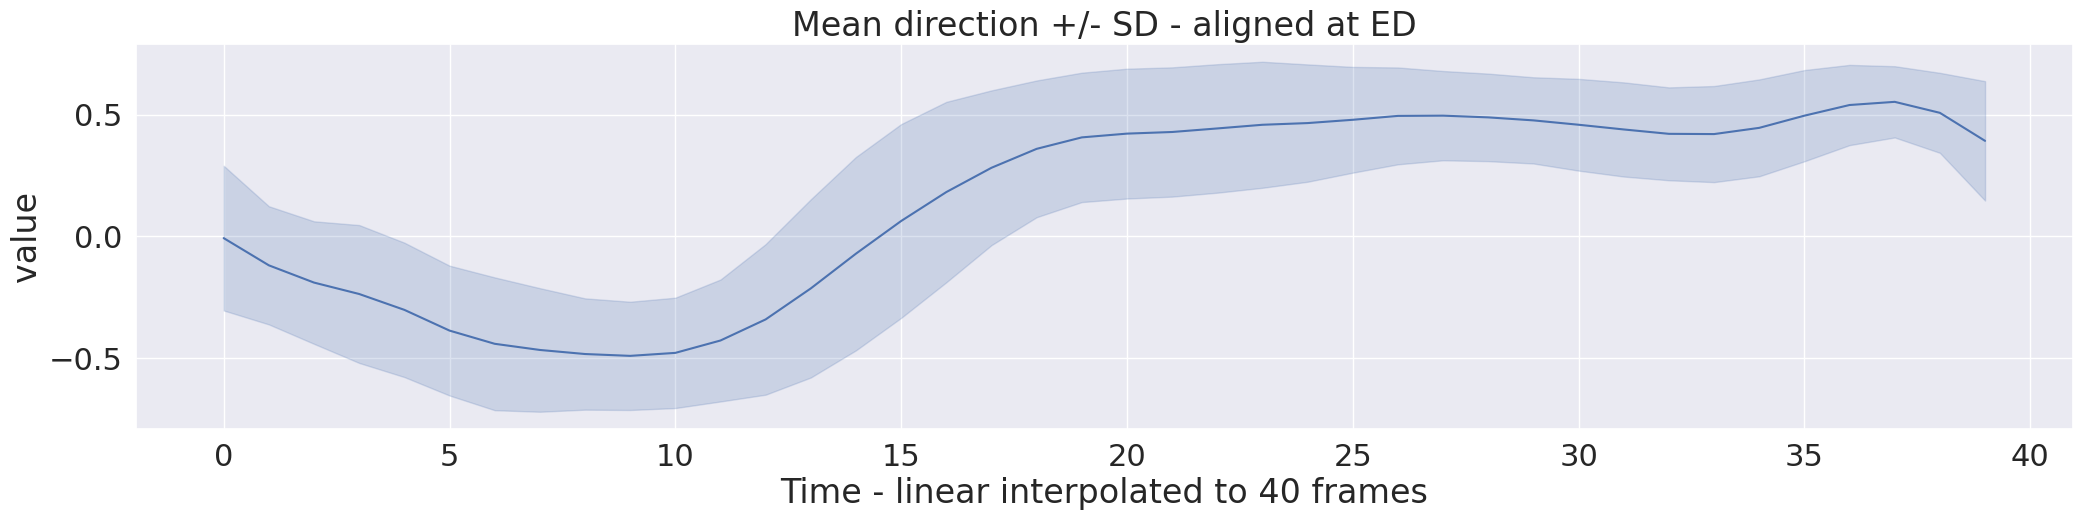

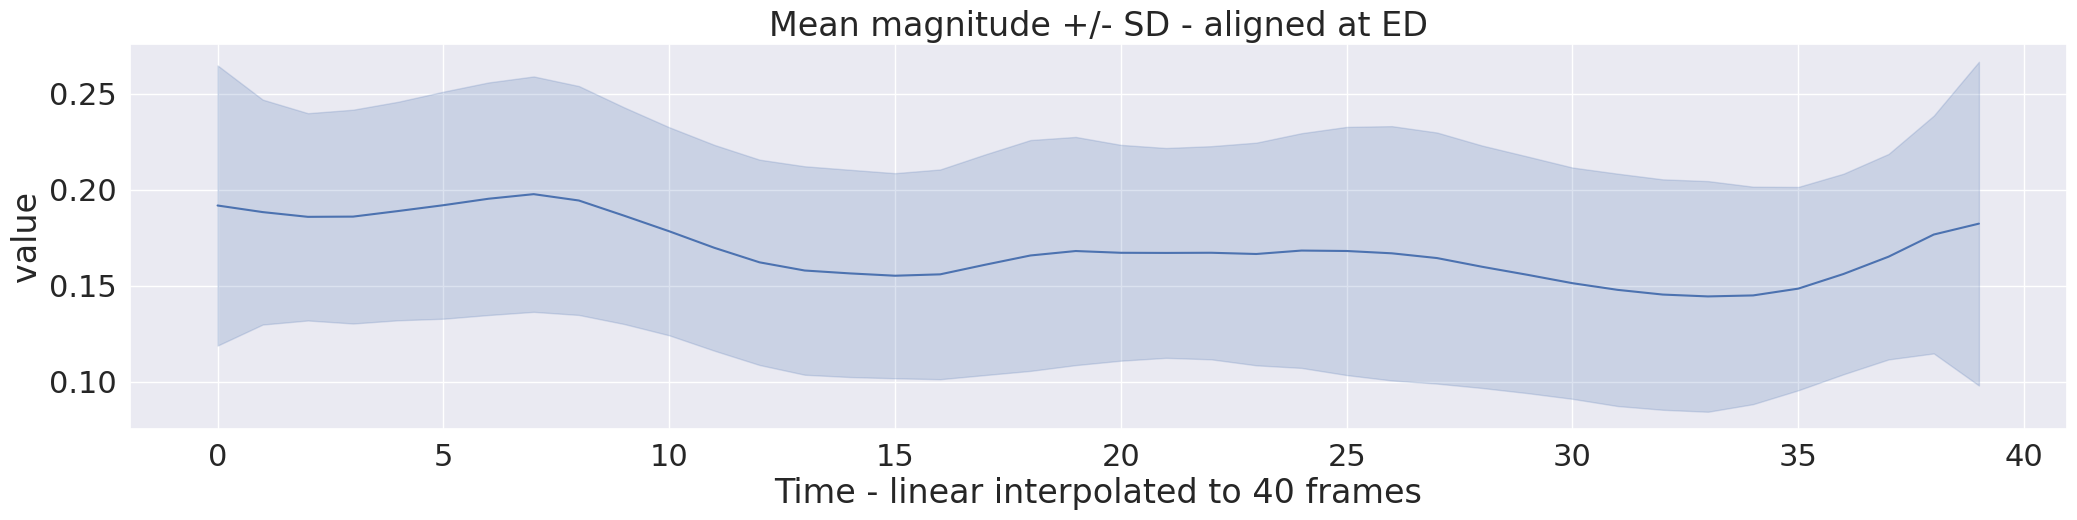

In [57]:
# seaborn
import seaborn as sb
sb.set_context('paper')
sb.set(font_scale = 2)
fig, ax = plt.subplots(figsize=(25,5))
df = pd.DataFrame(dirs).melt()
_ = sb.lineplot(x='variable', y='value',data=df,  ci='sd', legend=False,ax=ax)
_ = ax.set_title('Mean direction +/- SD - aligned at ED')
_ = ax.set_xlabel('Time - linear interpolated to 40 frames')

fig, ax = plt.subplots(figsize=(25,5))
df = pd.DataFrame(norms).melt()
_ = sb.lineplot(x='variable', y='value',data=df,  ci='sd', legend=False,ax=ax)
_ = ax.set_title('Mean magnitude +/- SD - aligned at ED')
_ = ax.set_xlabel('Time - linear interpolated to 40 frames')

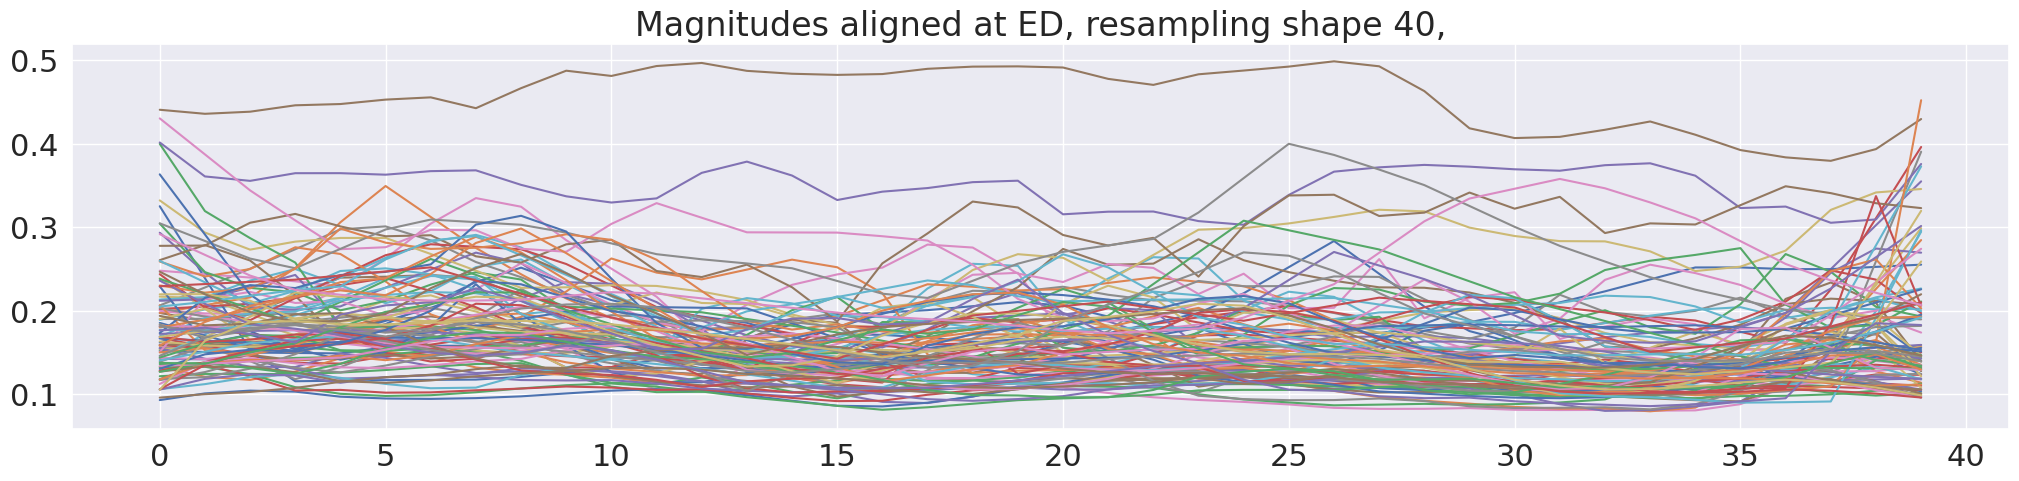

In [59]:
# plot one line per patient - norm
fig, ax = plt.subplots(figsize=(25,5))
for n in norms:
    _ = plt.plot(n)
_ = ax.set_title('Magnitudes aligned at ED, resampling shape 40,')

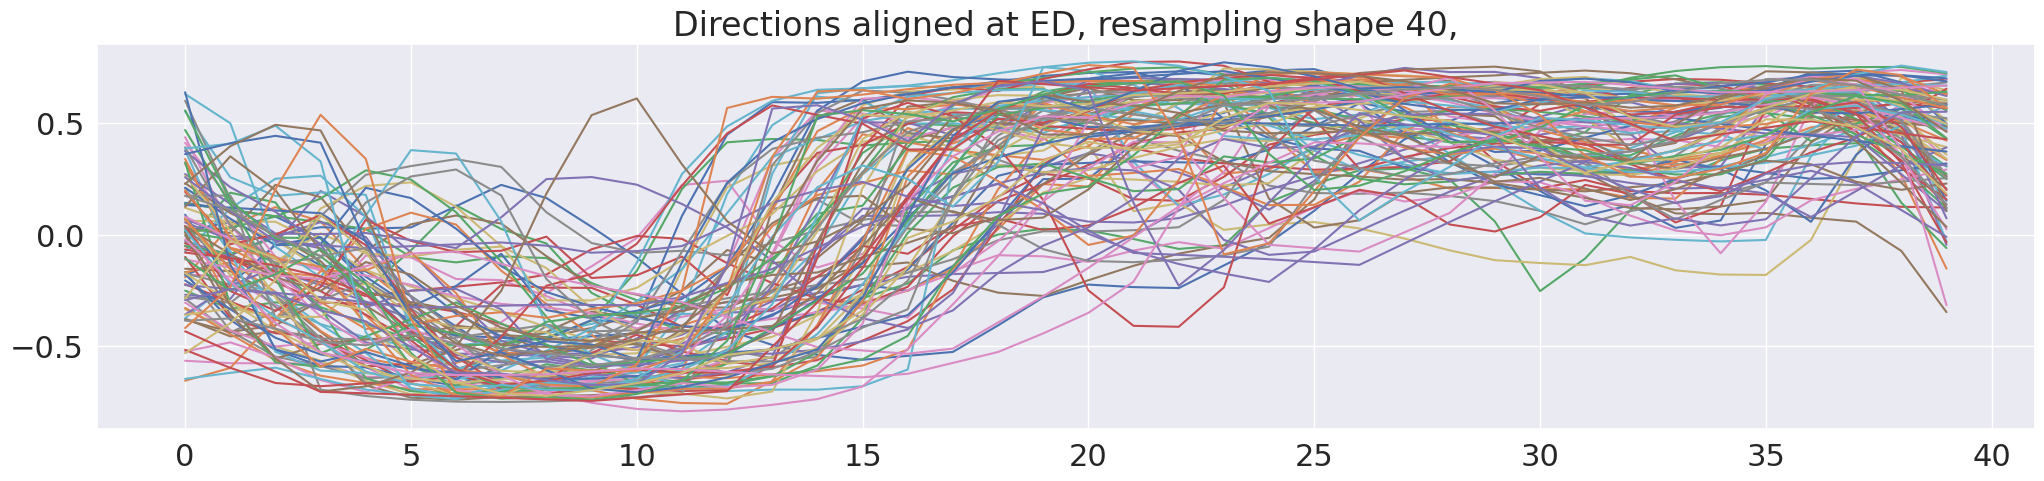

In [60]:
# plot one line per direction
fig, ax = plt.subplots(figsize=(25,5))
for n in dirs:
    _ = plt.plot(n)
_ = ax.set_title('Directions aligned at ED, resampling shape 40,')

## 3.2 Extract the vectorfield of one example patient

- validation of inplane alignment and spatial order (detect apex and base orientation in vect)
- further static plotting tests
- validate corner specific slicing

(40, 16, 64, 64)


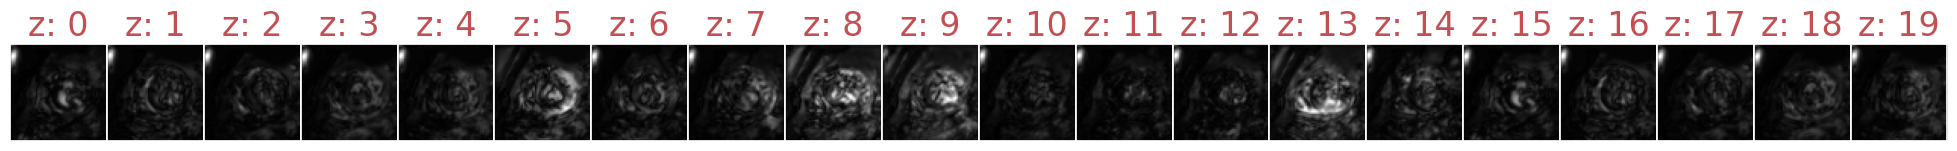

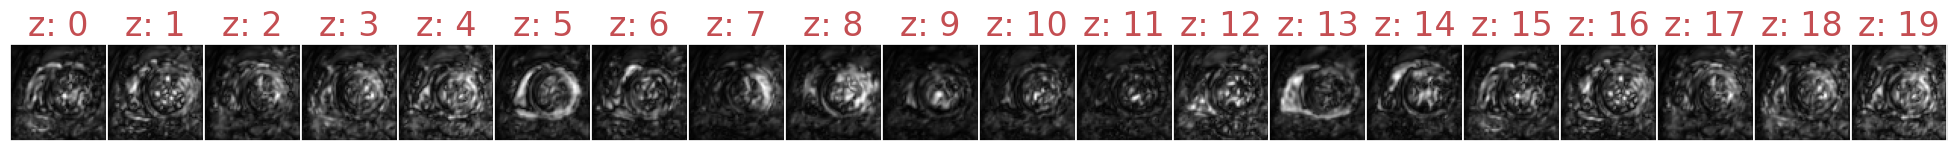

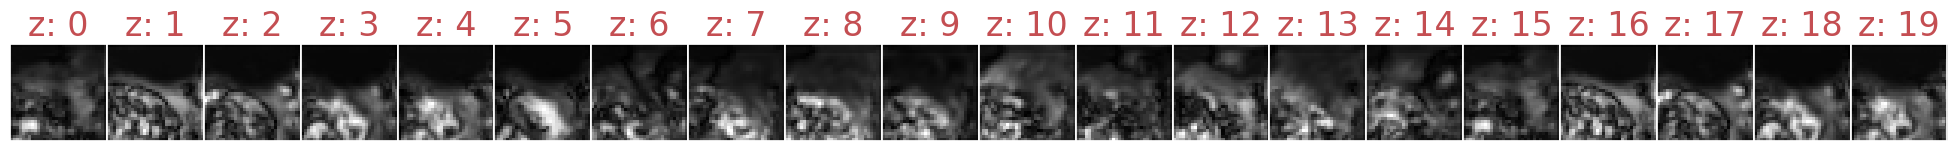

In [61]:
from src.visualization.Visualize import show_2D_or_3D
nda_temp = nda_vects[0]
# norm_1 = nda_temp[:,:,:32,:32]# top left
norm_1 = nda_temp[:,:,:32,32:]# top right
norm_1 = np.linalg.norm(norm_1, axis=-1)
nda_temp = np.linalg.norm(nda_temp, axis=-1)
print(nda_temp.shape)
_ = show_2D_or_3D(nda_temp[:,0], allow_slicing=True)
_ = show_2D_or_3D(nda_temp[:,-1], allow_slicing=True)

# top right
_ = show_2D_or_3D(norm_1[:,0], allow_slicing=True)

## 3.2 Plot the GT cardiac phase as steps over time

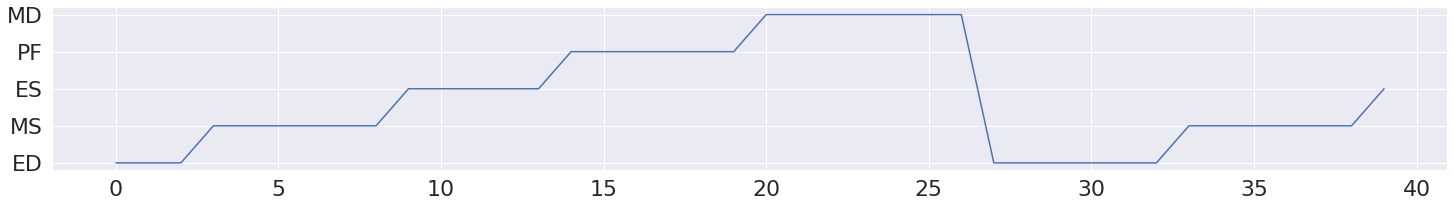

In [38]:
fig, ax = plt.subplots(figsize=(25,3))
plt.plot(np.argmax(gt[0], axis=1))
ax.set_yticks([0, 1, 2, 3, 4], minor=False)
phases = ['ED', 'MS', 'ES', 'PF', 'MD']
_ = ax.set_yticklabels(phases)

## 3.3 Plot the mean/max norm of the example patient

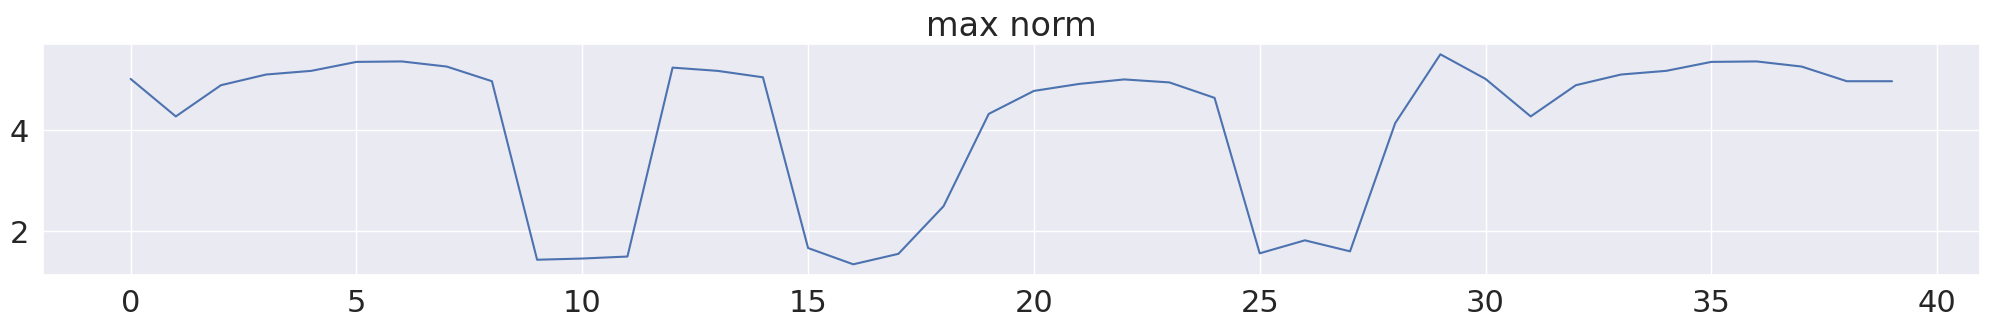

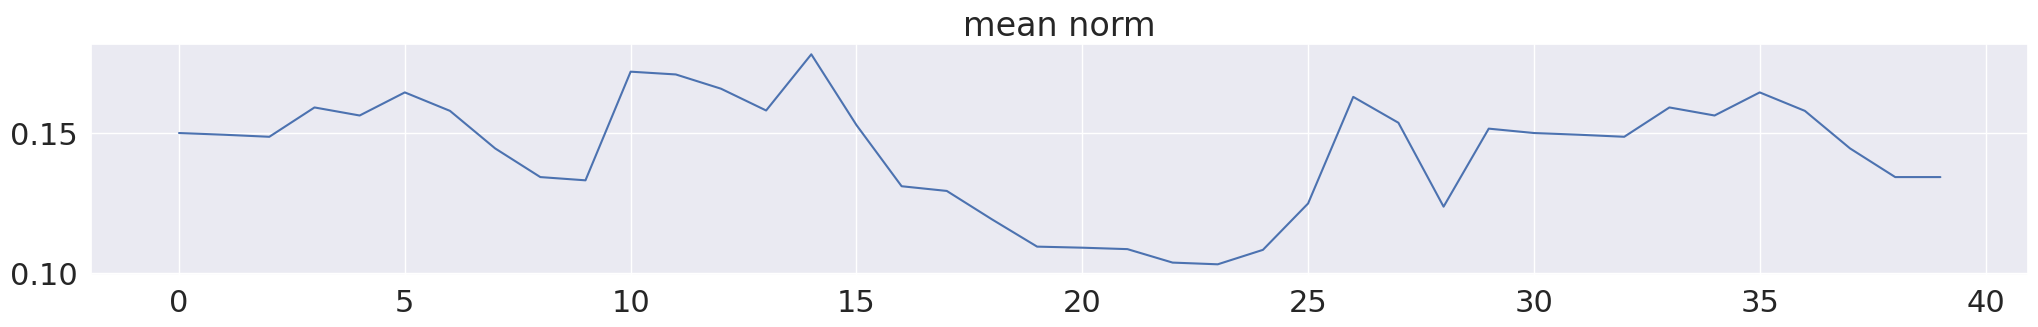

In [62]:
# plot the mean/max norm for one patient oveer time
nda_1d_max = np.max(nda_temp,axis=(1,2,3))
nda_1d_mean = np.mean(nda_temp,axis=(1,2,3))

fig, ax = plt.subplots(figsize=(25,3))
ax.set_title('max norm')
_ = plt.plot(nda_1d_max); plt.show()
fig, ax = plt.subplots(figsize=(25,3))
ax.set_title('mean norm')
_ = plt.plot(nda_1d_mean)
#ax.set_ylim(0.0,0.15)

In [63]:
import scipy.signal
import scipy.signal as sig
sig.find_peaks(nda_1d_mean)

(array([ 3,  5, 10, 14, 26, 29, 33, 35]), {})

# 4. Predict phases from the frame2frame deformable registration field

Here we define the rules to get from a deformable 5D registration field to the five cardiac phases 

die aktuelle unsupervised "Regel" zur Identifizierung der Phasen als Pseudo-Code (funktioniert ohne vorheriges Alignment an einer Phase):
Ich suche nach den Phasen sequentiell und croppe nach jedem Schritt die Norm und Direction-1D-Vektoren um 
a) sicher zu stellen das die Reihenfolge der Phasen stimmt und 
b) um das Problem jeweils kleiner/einfacher zu machen

MS = first negative peak of direction (if no peak given argmin(dir))

sub_dir = direction[MS: ]
ES = first idx where  sub_dir>0 (if no ES found, ES = MS +1)

sub_dir = direction[ES: ]
PF = first peak in sub_dir (if no PF found, PF = PF + 1)

sub_norm = norm[PF: ]
MD = argmin(sub_norm) (should show only the diastolic sequence, finds always a min)

sub_norm = norm[MD: ] + norm[:MS]
ED = first time sub_norm<0 (if no ED found, ED = 0)

gt ed: 0
direction shape: (17, 16, 64, 64)


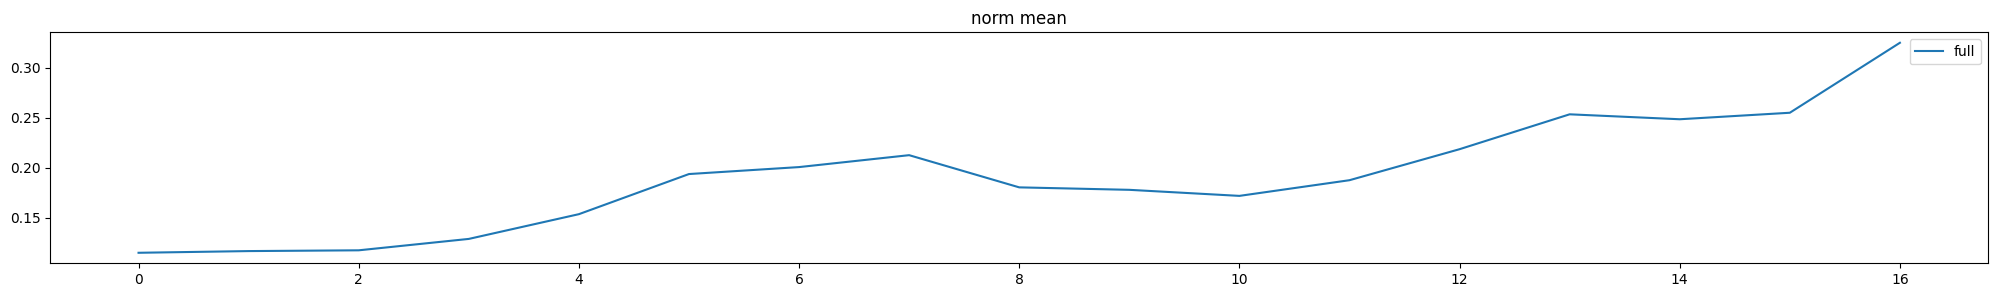

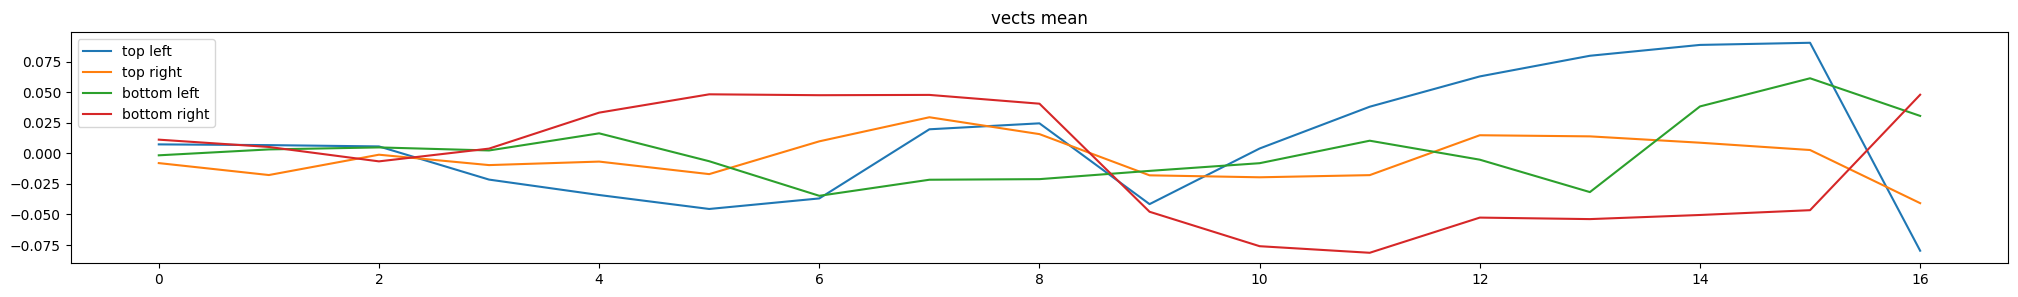

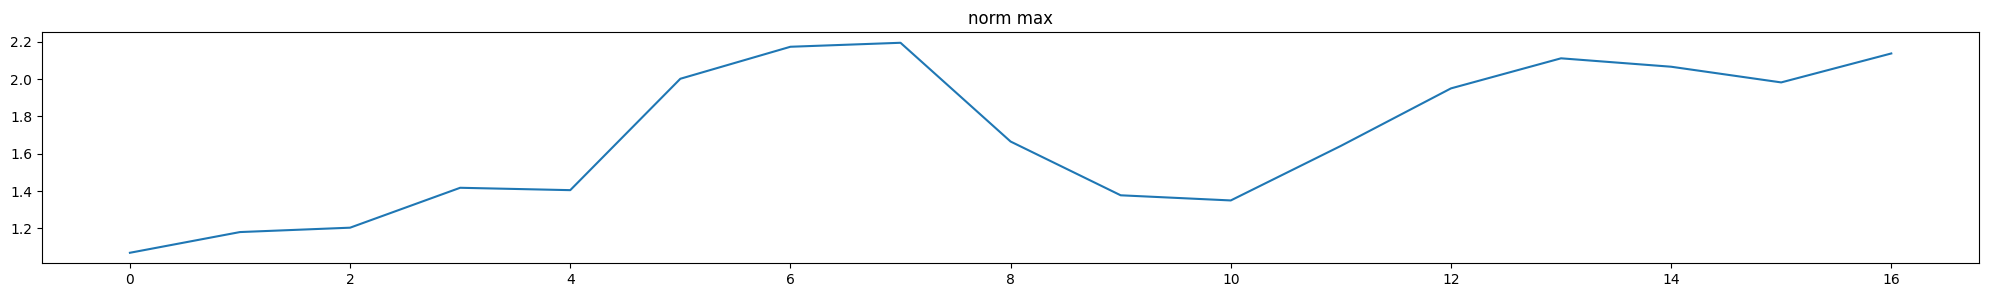

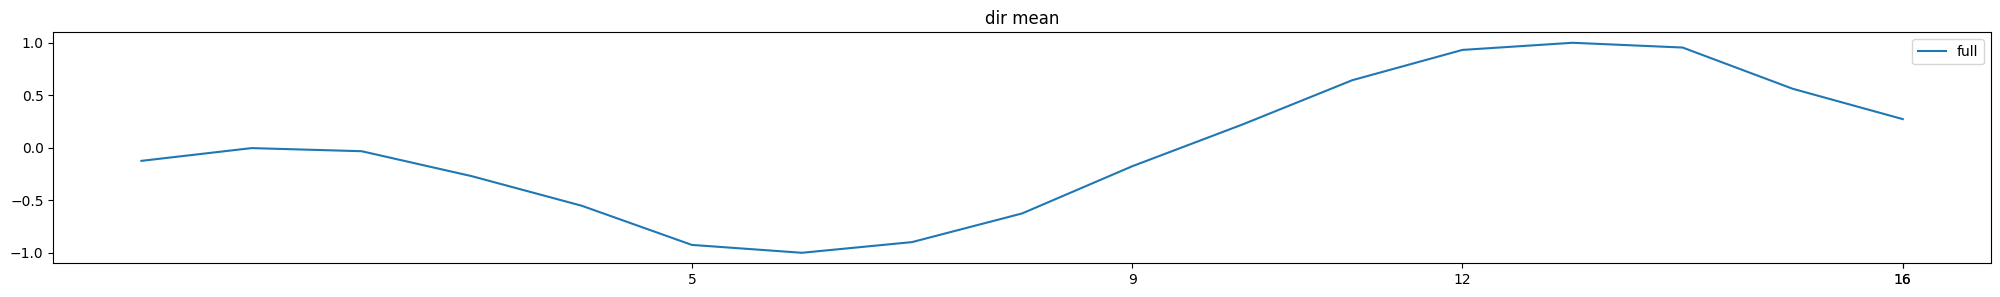

(16, 5, 9, 12, 16)

In [66]:
# try to predict the phases unsupervised just from the norm/direction curve

def get_phases_from_vects(vects_nda, length=-1, plot=True, dir_axis=0, gted=0):
    import scipy.signal
    import scipy.signal as sig
    vects_nda = vects_nda[:int(length)]
    print('gt ed: {}'.format(gted))
    #print(vects_nda.shape)
    vects_1 = vects_nda[:,:,:32,:32,:]
    vects_1 = np.mean(vects_1,axis=(1,2,3,4))
    
    vects_2 = vects_nda[:,:,:32,32:,:]
    vects_2 = np.mean(vects_2,axis=(1,2,3,4))
    
    vects_3 = vects_nda[:,:,32:,:32,:]
    vects_3 = np.mean(vects_3,axis=(1,2,3,4))
    
    vects_4 = vects_nda[:,:,32:,32:,:]
    vects_4 = np.mean(vects_4,axis=(1,2,3,4))
    #vects_nda = vects_nda[:,4:-4]
    dim = vects_nda.shape[1:-1]
    #print(dim)
    idx = get_idxs_tf(dim)
    c = get_centers_tf(dim)
    #print('centers: ',c.dtype)
    centers = c - idx
    centers_tensor = centers[tf.newaxis, ...]
    flow2direction_lambda = tf.keras.layers.Lambda(
            lambda x: get_angle_tf(x[...,dir_axis:], centers_tensor[...,dir_axis:]), name='flow2direction')
    #print(centers_tensor.shape)
    # signal smoothing
    kernel_size = 4
    kernel = np.ones(kernel_size) / kernel_size
    
    # norm of the vector
    norm_nda = np.linalg.norm(vects_nda[...,dir_axis:], axis=-1)
    nda_1d_mean = np.mean(norm_nda,axis=(1,2,3))
    nda_1d_max = np.max(norm_nda,axis=(1,2,3))
    nda_1d_median = np.median(norm_nda,axis=(1,2,3))
    nda_1d_mean_smooth = np.convolve(nda_1d_mean, kernel, mode='same')
    #print(nda_1d_mean_smooth.shape, nda_1d_mean.shape)
    
    
    # direction relative to the center
    directions = flow2direction_lambda(vects_nda)[...,0]
    dir_1d_mean = np.mean(directions,axis=(1,2,3))
    dir_1d_median = np.median(directions,axis=(1,2,3))
    dir_1d_mean_smooth = np.convolve(dir_1d_mean, kernel, mode='same')
    print('direction shape:',directions.shape)
    
    y,x = directions.shape[-2:]
    dir_1 = directions[:,:,:y//2,:x//2] # top left, plot
    dir_1_mean = np.mean(dir_1,axis=(1,2,3))
    dir_2 = directions[:,:,y//2:,:x//2] # top right, plot
    dir_2_mean = np.mean(dir_1,axis=(1,2,3))
    dir_3 = directions[:,:,y//2:,x//2:] # bottom left
    dir_3_mean = np.mean(dir_3,axis=(1,2,3))
    dir_4 = directions[:,:,:y//2,x//2:] # bottom right
    dir_4_mean = np.mean(dir_4,axis=(1,2,3))
    
    norm_1 = norm_nda[:,:,:y//2,:x//2]
    norm_1_mean = np.mean(norm_1,axis=(1,2,3))
    norm_2 = norm_nda[:,:,y//2:,:x//2]
    norm_2_mean = np.mean(norm_1,axis=(1,2,3))
    norm_3 = norm_nda[:,:,y//2:,x//2:]
    norm_3_mean = np.mean(norm_3,axis=(1,2,3))
    norm_4 = norm_nda[:,:,:y//2,x//2:]
    norm_4_mean = np.mean(norm_4,axis=(1,2,3))
    

    
    # find phases
    # try with smoothed direction to avoid small peaks
    lower = -1
    upper = 1
    dir_1d_mean = np.convolve(dir_1d_mean, kernel, mode='same')
    # normalise to a direction between -1 and 1
    minmax_lambda = lambda x : x[1] + (((x[0] - min(x[0])) * (x[2]-x[1]))/(max(x[0]) - min(x[0])))
    dir_1d_mean = minmax_lambda([dir_1d_mean,lower,upper])
    
    import scipy.signal as sig
    
    # find ms by first negative peak in direction
    neg_peaks = sig.find_peaks(dir_1d_mean*-1)[0]
    if len(neg_peaks>0):
        ms = neg_peaks[0] -1 # take the bucket before the first min peak
    else:
        ms = np.argmin(dir_1d_mean)
        
    # find es from ms --> first time f(x)>0
    seq = dir_1d_mean[ms:]
    temp_ = 0
    es_found=False
    negative_slope = False
    for idx,elem in enumerate(seq):
        if elem<0:
            negative_slope=True
            temp_ = idx
        if elem>0 and negative_slope:
            es_found = True
            #if abs(elem)<abs(temp_): # take the elem which is closer to 0
            temp_ = idx
            break
    if es_found:
        es = ms + temp_
        es = es -1 # it is the phase before
    else:
        es = ms + 1
    
    
    # find pf from es first peak in dir
    seq = dir_1d_mean[es:]
    peaks = sig.find_peaks(seq)[0]
    if len(peaks>0):
        pf = es + peaks[0] -1# take the first min peak
    else:
        pf = es + 1
        
    # find md from pf try the first negative peak, otherwise take argmin(seq_norm)
    seq = nda_1d_mean_smooth[pf:]

    md = pf + np.argmin(seq)
    if md <= pf or (length-md)<1:
        md = (pf+length)//2
    
    # ed is between md and ms where dir mean first time smaller 0
    cycle = np.concatenate([dir_1d_mean[md:][::-1], dir_1d_mean[:1]])
    temp_ = 0
    ed_found = False
    positive_slope = False
    for idx,elem in enumerate(cycle):
        if elem>0:
            positive_slope=True
            temp_ = idx
        if elem<0 and positive_slope:
            ed_found = True
            #temp_ = idx
            break
    if ed_found:
        ed = md + temp_
    else: ed = 0
        
    if ed>=length-1:
        ed = np.mod(ed,length)    
    
    ind = ed,ms,es,pf,md
    
    
    #print('ed: {}, ms: {}, es: {}, pf: {}, md: {}'.format(*ind))
    
        # plot the mean/max norm for one patient oveer time
    if plot:
        fig, ax = plt.subplots(figsize=(25,3))
        ax.set_title('norm mean')
        _ = plt.plot(nda_1d_mean, label='full')
        #_ = plt.plot(norm_1_mean, label='top left')
        #_ = plt.plot(norm_2_mean, label='top right')
        #_ = plt.plot(norm_3_mean, label='bottom left')
        #_ = plt.plot(norm_4_mean, label='bottom right')
        ax.legend()
        plt.show()
        
        fig, ax = plt.subplots(figsize=(25,3))
        ax.set_title('vects mean')
        _ = plt.plot(vects_1, label='top left')
        _ = plt.plot(vects_2, label='top right')
        _ = plt.plot(vects_3, label='bottom left')
        _ = plt.plot(vects_4, label='bottom right')
        ax.legend()
        plt.show()
        
        
        
        fig, ax = plt.subplots(figsize=(25,3))
        ax.set_title('norm max')
        _ = plt.plot(nda_1d_max); plt.show()
        """fig, ax = plt.subplots(figsize=(25,3))
        ax.set_title('norm mean smooth')
        _ = plt.plot(nda_1d_mean_smooth);plt.show()"""

        # plot the mean/median smoothed mean direction
        fig, ax = plt.subplots(figsize=(25,3))
        ax.set_title('dir mean')
        ax.set_xticks(ind, minor=False)
        _ = plt.plot(dir_1d_mean, label='full')
        #_ = plt.plot(np.roll(dir_1d_mean,-1*gted), label='roll by ED = {}'.format(gted))
        #_ = plt.plot(dir_1_mean, label='top left')
        #_ = plt.plot(dir_2_mean, label='top right')
        #_ = plt.plot(dir_3_mean, label='bottom left')
        #_ = plt.plot(dir_4_mean, label='bottom right')
        ax.legend()
        plt.show()
        """fig, ax = plt.subplots(figsize=(25,3))
        ax.set_title('dir median')
        _ = plt.plot(dir_1d_median); plt.show()
        fig, ax = plt.subplots(figsize=(25,3))
        ax.set_title('dir mean smooth')
        _ = plt.plot(dir_1d_mean_smooth);plt.show()"""
        
    
    return ind
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
get_phases_from_vects(nda_vects[10], length=int(gt_len[10,:,0].sum()),plot=True,dir_axis=0)

# 5. Interactive comparison: GT, norm, direction, unsupervised pred und supervised pred

In [67]:
@interact
def compare_phases(i=(0,nda_vects.shape[0]-1), plot=True):
    
    weight = 1
    phases = ['ED', 'MS', 'ES', 'PF', 'MD']
    ind = np.argmax(gt[i],axis=0)
    ind_pred = np.argmax(pred[i],axis=0)
    
    
    fig, ax = plt.subplots(figsize=(25,4))
    ax.set_xticks(ind, minor=False)
    ax.set_yticks([0, 1, 2, 3, 4], minor=False)
    ax.set_yticklabels(phases, rotation=45)
    cardiac_cycle_length = int(gt_len[i,:,0].sum())
    #print(gt[i][:cardiac_cycle_length].T.shape)
    plt.imshow(gt[i][:cardiac_cycle_length].T,aspect='auto')
    _ = ax.set_yticklabels(phases);plt.show()
    
    indices = get_phases_from_vects(nda_vects[i], length=cardiac_cycle_length, plot=plot,dir_axis=0, gted=ind[0])
    print(phases)
    print('gt:', ind)
    print('u: ', indices)
    print('p: ', ind_pred)
    
    indices = np.array(indices)
    onehot = np.zeros((indices.size, cardiac_cycle_length))
    onehot[np.arange(indices.size), indices] = weight
    fig, ax = plt.subplots(figsize=(25,4))
    ax.set_xticks(indices, minor=False)
    ax.set_yticks([0, 1, 2, 3, 4], minor=False)
    ax.set_yticklabels(phases, rotation=45)
    plt.imshow(onehot,aspect='auto')
    _ = ax.set_yticklabels(phases);plt.show()
    
    
    fig, ax = plt.subplots(figsize=(25,4))
    ax.set_xticks(ind_pred, minor=False)
    ax.set_yticks([0, 1, 2, 3, 4], minor=False)
    ax.set_yticklabels(phases, rotation=45)
    plt.imshow(pred[i][:cardiac_cycle_length].T,aspect='auto')
    _ = ax.set_yticklabels(phases);plt.show()

interactive(children=(IntSlider(value=49, description='i', max=98), Checkbox(value=True, description='plot'), …

# 6. Predict with unsupervised rule from 4. the phases for all patients

In [43]:
pred_u = np.zeros_like(gt)
print(pred_u.shape)
for i in range(pred_u.shape[0]):
    weight = 1
    
    cardiac_cycle_length = int(gt_len[i,:,0].sum())
    #print(gt[i][:cardiac_cycle_length].T.shape)
    
    indices = get_phases_from_vects(nda_vects[i], length=cardiac_cycle_length, plot=False,dir_axis=0)
    #print(indices)
    indices = np.array(indices)
    onehot = np.zeros((indices.size, cardiac_cycle_length))
    onehot[np.arange(indices.size), indices] = weight
    pred_u[i][0:cardiac_cycle_length] = onehot.T

(25, 40, 5)
gt ed: 0
direction shape: (30, 16, 64, 64)
gt ed: 0
direction shape: (30, 16, 64, 64)
gt ed: 0
direction shape: (35, 16, 64, 64)
gt ed: 0
direction shape: (30, 16, 64, 64)
gt ed: 0
direction shape: (13, 16, 64, 64)
gt ed: 0
direction shape: (30, 16, 64, 64)
gt ed: 0
direction shape: (28, 16, 64, 64)
gt ed: 0
direction shape: (30, 16, 64, 64)
gt ed: 0
direction shape: (35, 16, 64, 64)
gt ed: 0
direction shape: (24, 16, 64, 64)
gt ed: 0
direction shape: (17, 16, 64, 64)
gt ed: 0
direction shape: (35, 16, 64, 64)
gt ed: 0
direction shape: (35, 16, 64, 64)
gt ed: 0
direction shape: (30, 16, 64, 64)
gt ed: 0
direction shape: (30, 16, 64, 64)
gt ed: 0
direction shape: (30, 16, 64, 64)
gt ed: 0
direction shape: (30, 16, 64, 64)
gt ed: 0
direction shape: (30, 16, 64, 64)
gt ed: 0
direction shape: (30, 16, 64, 64)
gt ed: 0
direction shape: (30, 16, 64, 64)
gt ed: 0
direction shape: (16, 16, 64, 64)
gt ed: 0
direction shape: (17, 16, 64, 64)
gt ed: 0
direction shape: (30, 16, 64, 64)

In [44]:
# re-create a shape for the metric fn
gt_ = np.stack([gt,gt_len], axis=1)
pred_ = np.stack([pred_u,np.zeros_like(pred_u)], axis=1)

In [45]:
from src.utils.Metrics import meandiff
phases = ['ED', 'MS', 'ES', 'PF', 'MD']
res = meandiff(gt_, pred_, apply_sum=False, apply_average=False)
df = pd.DataFrame(res.numpy(), columns=phases)

Instructions for updating:
Use fn_output_signature instead


## 6.1 Plot the unsupervised error per Cardiac Phase

ED    0.80
MS    1.40
ES    0.92
PF    2.64
MD    2.12
dtype: float32


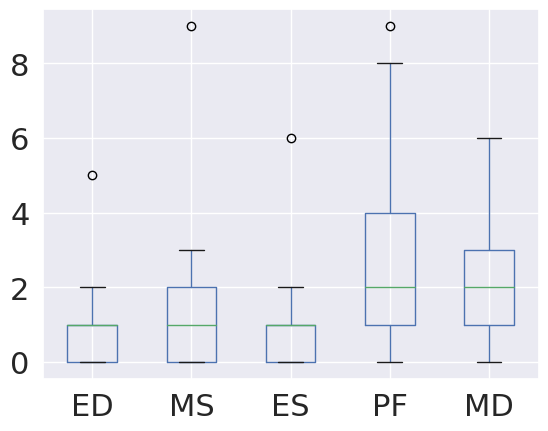

In [46]:
# TOF unsupervised
sb.set_context('paper')
sb.set(font_scale = 2)
print(df.mean())
_ =df.plot(kind='box')

ED    1.646465
MS    1.323232
ES    1.161616
PF    2.262626
MD    2.535353
dtype: float32


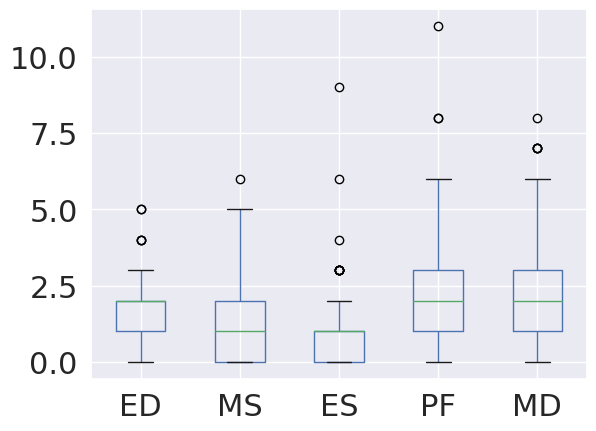

In [121]:
# ACDC unsupervised
sb.set_context('paper')
sb.set(font_scale = 2)
print(df.mean())
_ =df.plot(kind='box')

# 7. Additional plots with imshow of vect, direction and magnitude

(16, 64, 64)
(1, 40, 16, 64, 64, 1)


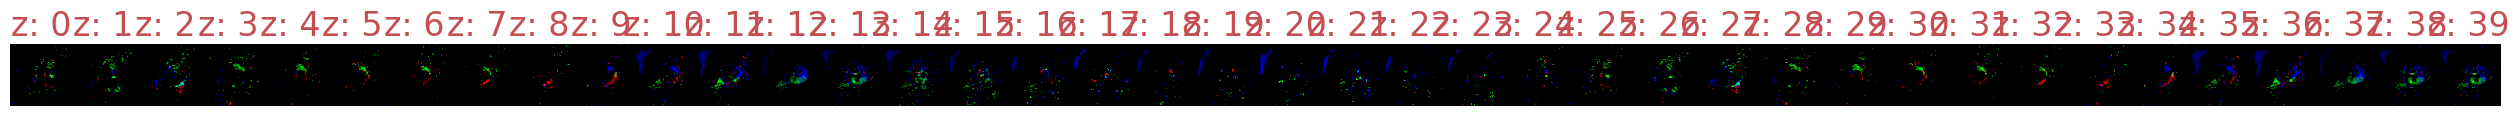

In [36]:
# Take one spatial slice from the middle and plot the vect as RGB image
dim = nda_vects[0].shape[1:-1]
print(dim)
idx = get_idxs_tf(dim)
c = get_centers_tf(dim)
#print('centers: ',c.dtype)
centers = c - idx
centers_tensor = centers[tf.newaxis, ...]
flow2direction_lambda = tf.keras.layers.Lambda(
        lambda x: get_angle_tf(x, centers_tensor), name='flow2direction')
directions = flow2direction_lambda(nda_vects[0:1])
print(directions.shape)
_ = show_2D_or_3D(nda_vects[0,:,4],allow_slicing=False)

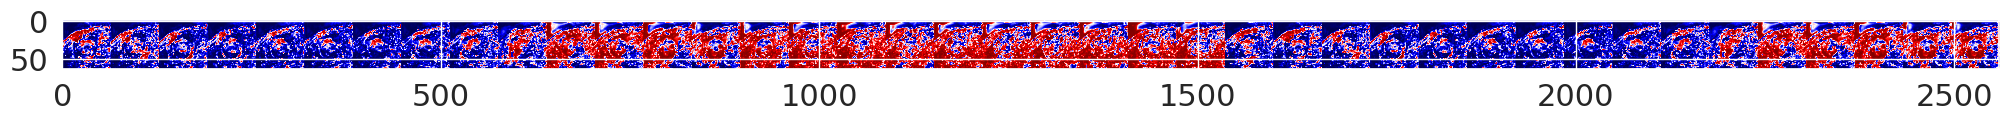

In [39]:
# Take one spatial slice from the middle and plot the direction with seismic scaling
fix, ax = plt.subplots(figsize=(25,5))
temp_dir = directions[0,:,4,...,0]
plt.imshow(np.reshape(temp_dir, (40*64,64)).T, cmap='seismic')

(1, 40, 16, 64, 64)


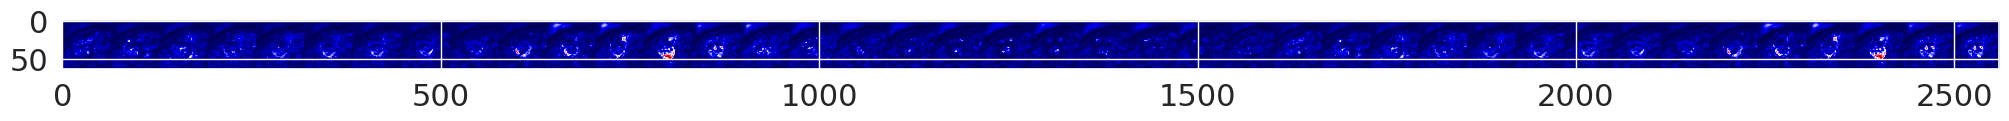

In [40]:
# Take one spatial slice from the middle and plot the vect as RGB image
fix, ax = plt.subplots(figsize=(25,5))
norm_nda = np.linalg.norm(nda_vects[0:1], axis=-1)
print(norm_nda.shape)
temp_dir = norm_nda[0,:,4]
plt.imshow(np.reshape(temp_dir, (40*64,64)).T, cmap='seismic')

## 7.1 Ploting of the vector norm (t and z) & the gt phases for n example patientens

Notes:
- Checked the order of the z axis (starts at apex goes to base)
- bright means greater motion
 
Most of the time:
- more motion (according to the norm of the deformable registration) at the base, than at the apex
- there is a strong negative slope of the norm curve close to the MD phase
- there is a positive peak of the norm curve close to MS and PF

(40, 16)


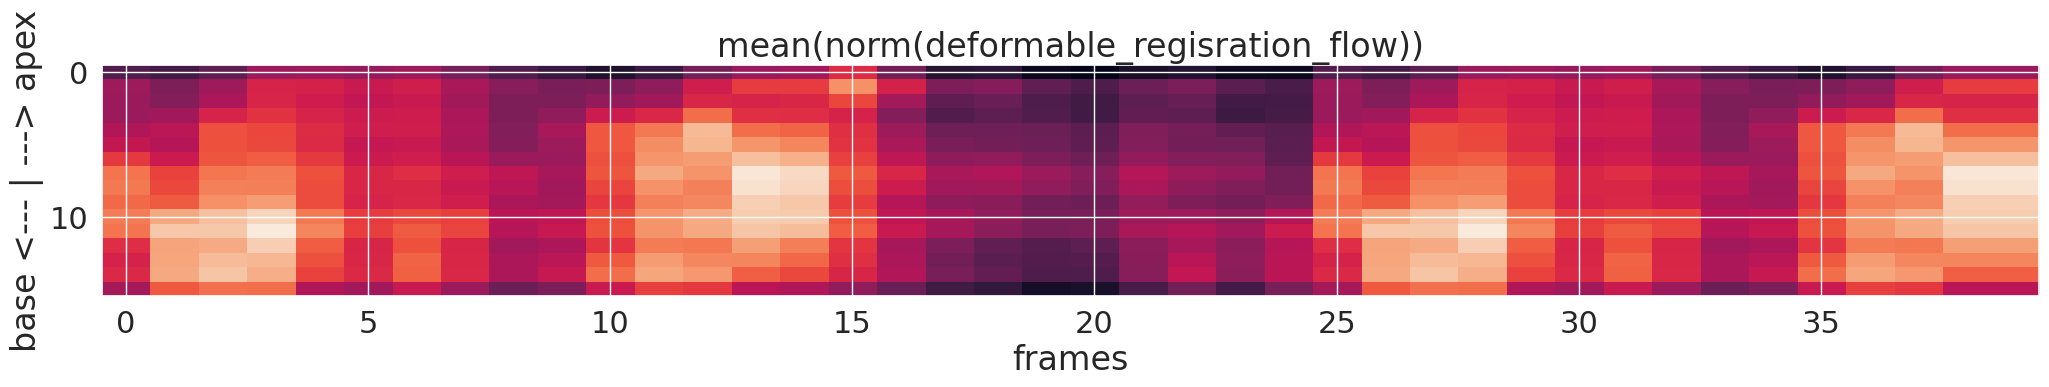

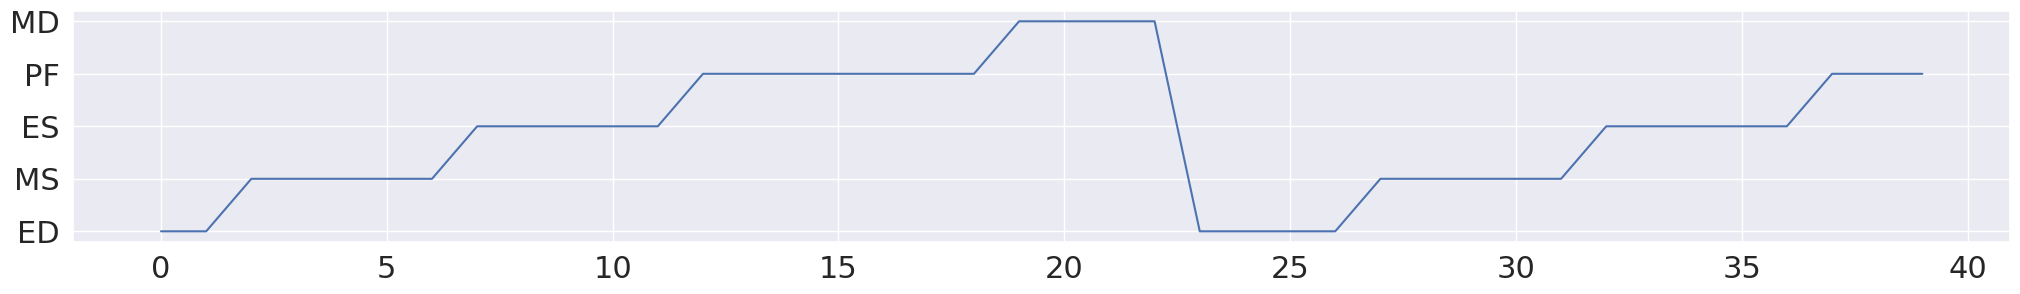

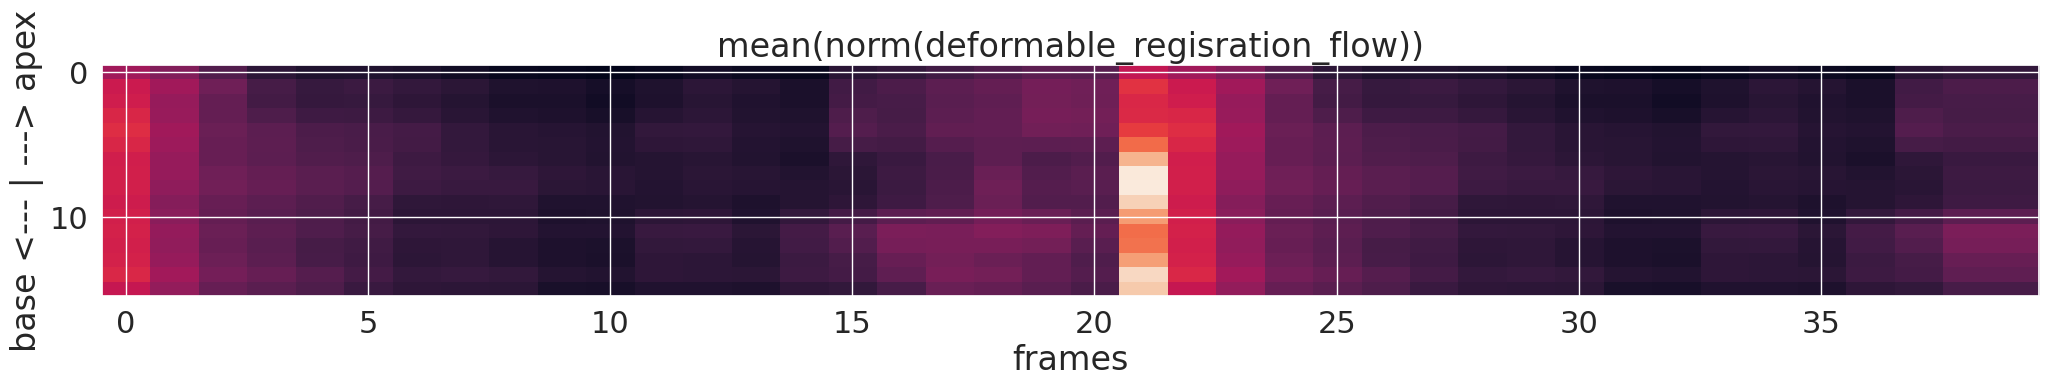

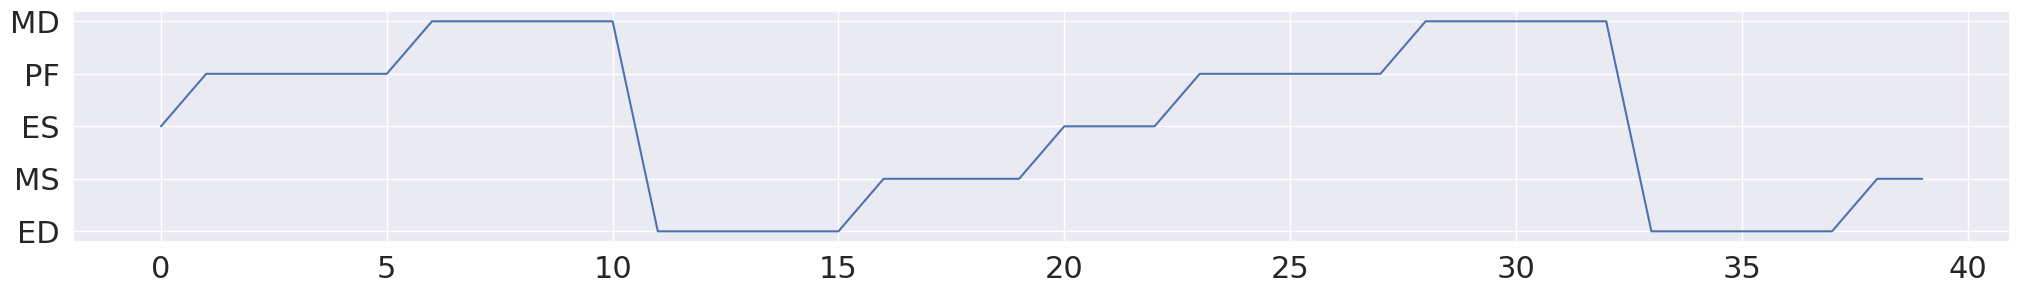

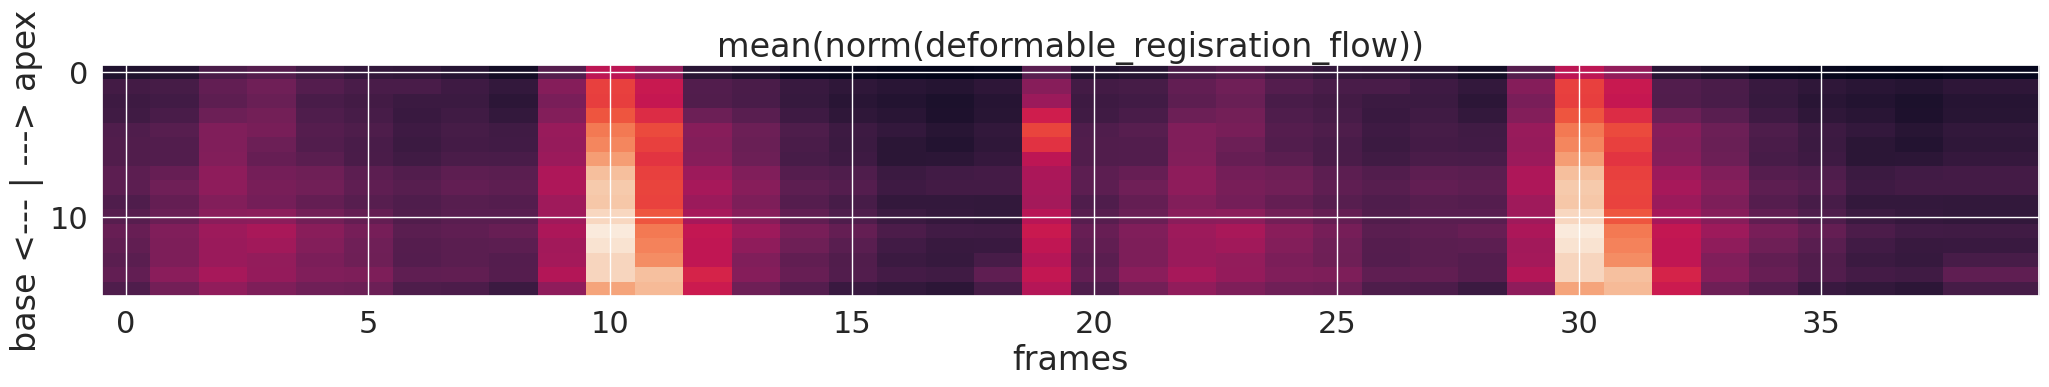

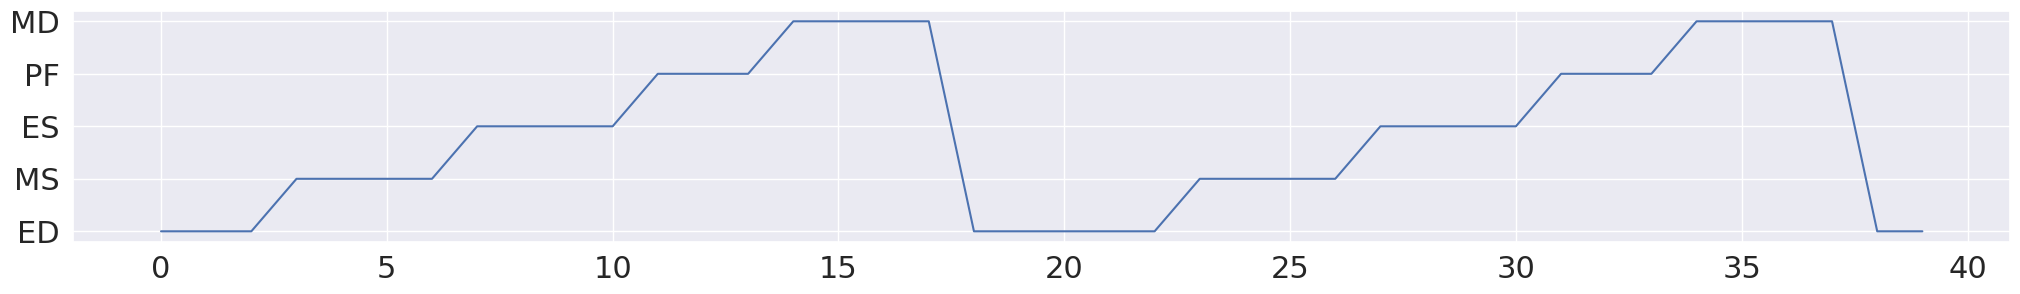

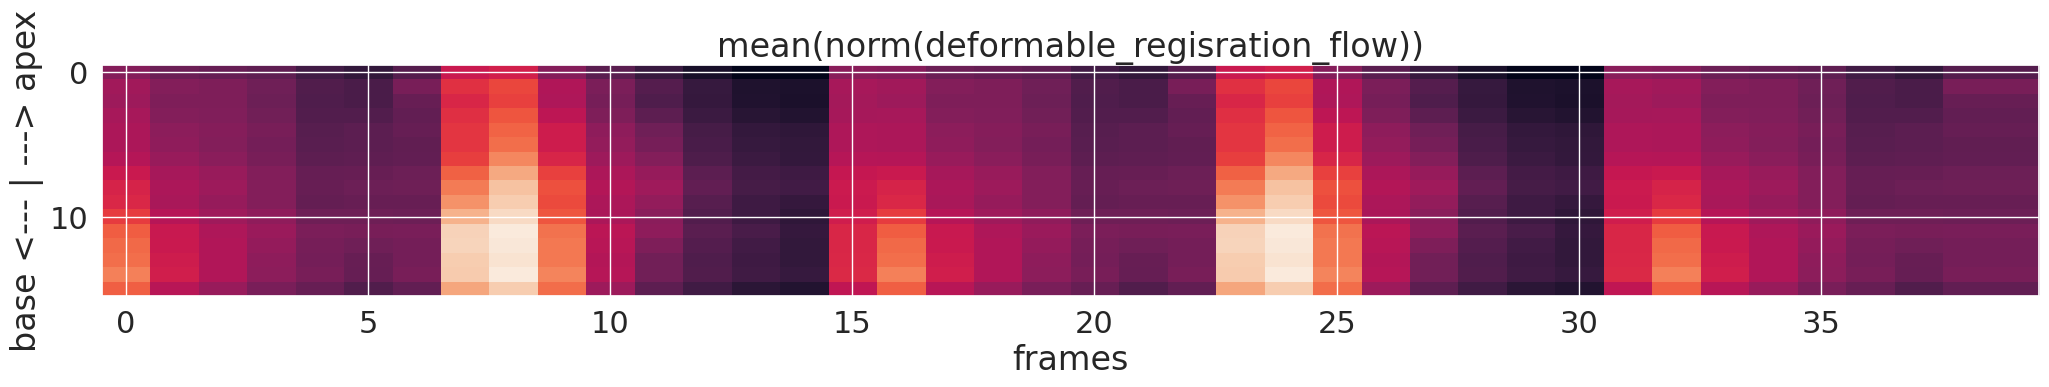

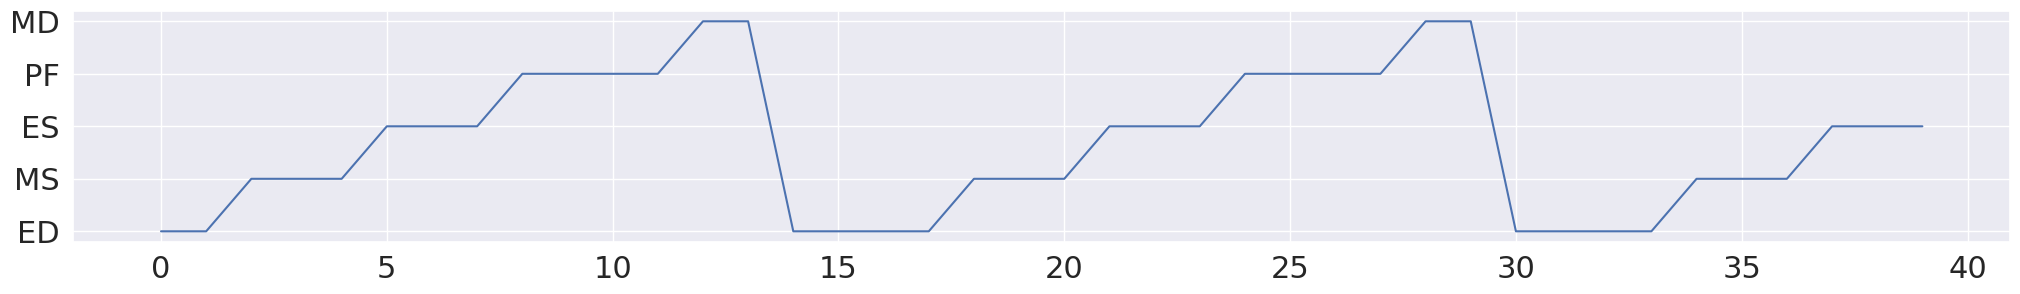

In [42]:
# plot vector norm (t x z) and the gt phases for n patientens
examples = 4
ndas = []
for n in nda_vects[0:examples]:
    ndas.append(np.linalg.norm(n, axis=-1).mean(axis=(2,3)))
print(ndas[0].shape)
for i in range(len(ndas)):
    fig, ax = plt.subplots(figsize=(25,3))
    n = ndas[i]
    _ = plt.imshow(n.T, aspect='auto')
    _ = ax.set_title('mean(norm(deformable_regisration_flow))')
    _ =ax.set_ylabel('base <--- | ---> apex')
    _ =ax.set_xlabel('frames')
    
    fix, ax = plt.subplots(figsize=(25,3))
    _ = plt.plot(np.argmax(gt[i], axis=1))
    phases = ['ED', 'MS', 'ES', 'PF', 'MD']
    _ = ax.set_yticks([0, 1, 2, 3, 4], minor=False)
    _ = ax.set_yticklabels(phases)


## 7.2 Ploting of the vector direction (t and z) & the gt phases for n example patientens

(40, 16, 64, 64, 1)
(40, 16, 64, 64, 1)
(40, 16, 64, 64, 1)
(40, 16, 64, 64, 1)


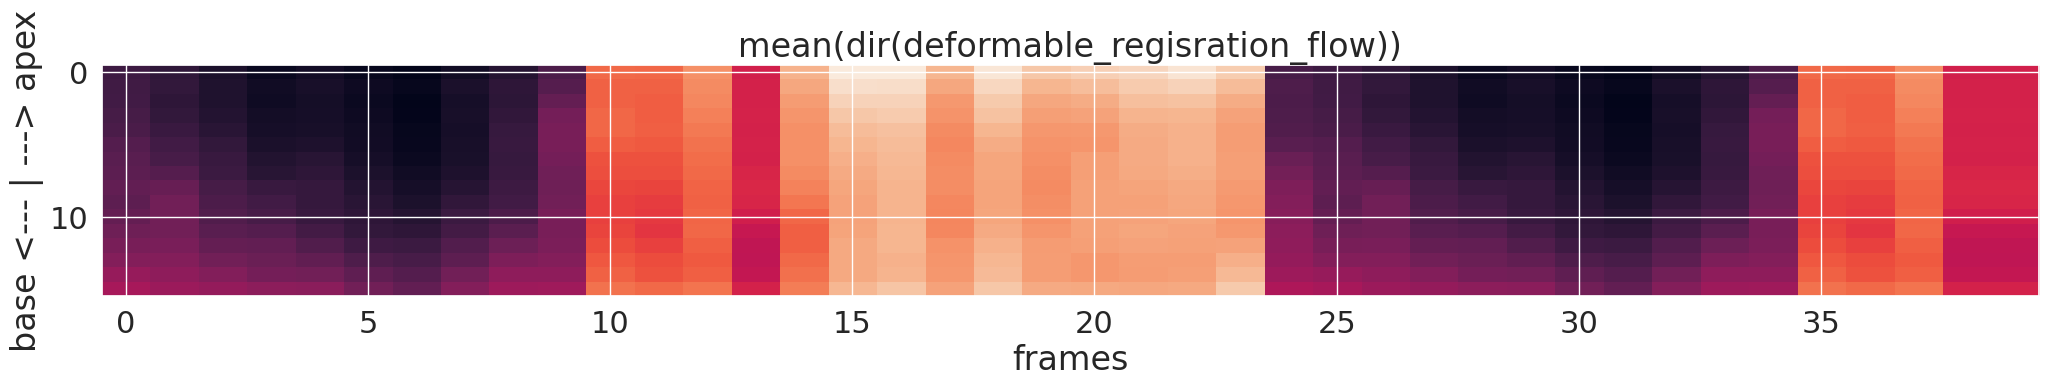

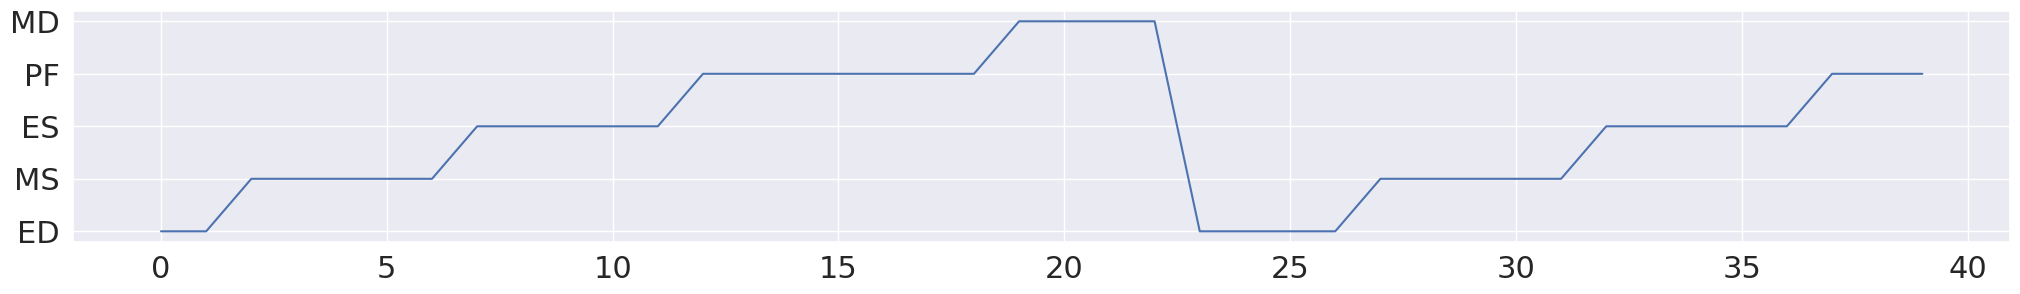

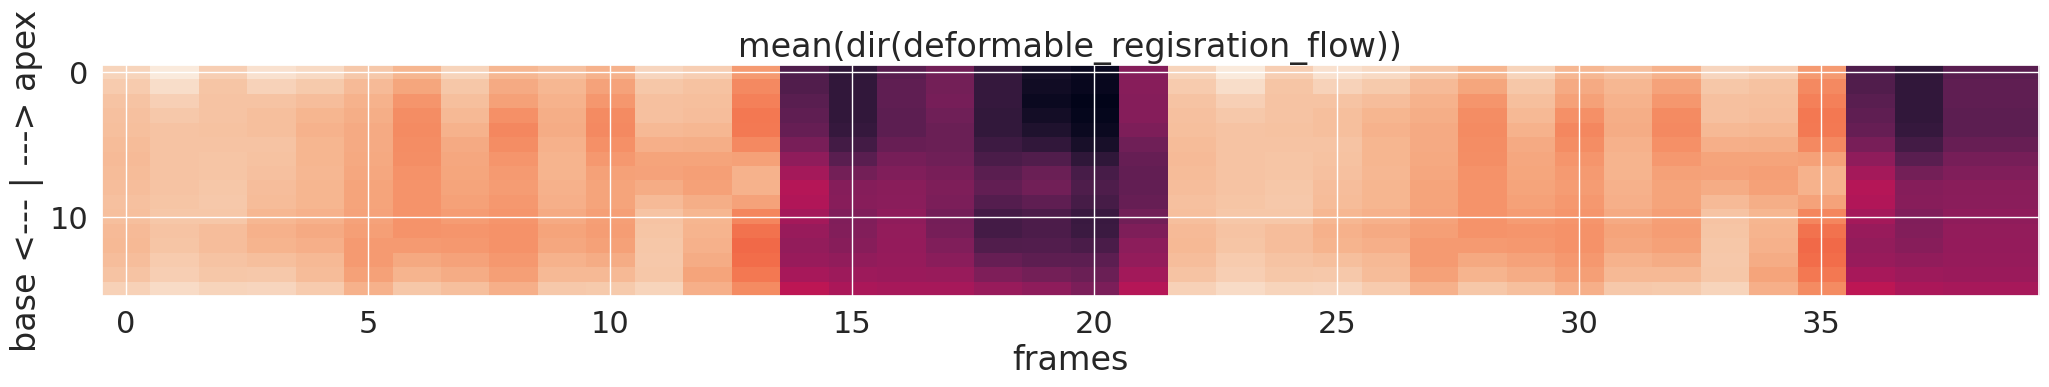

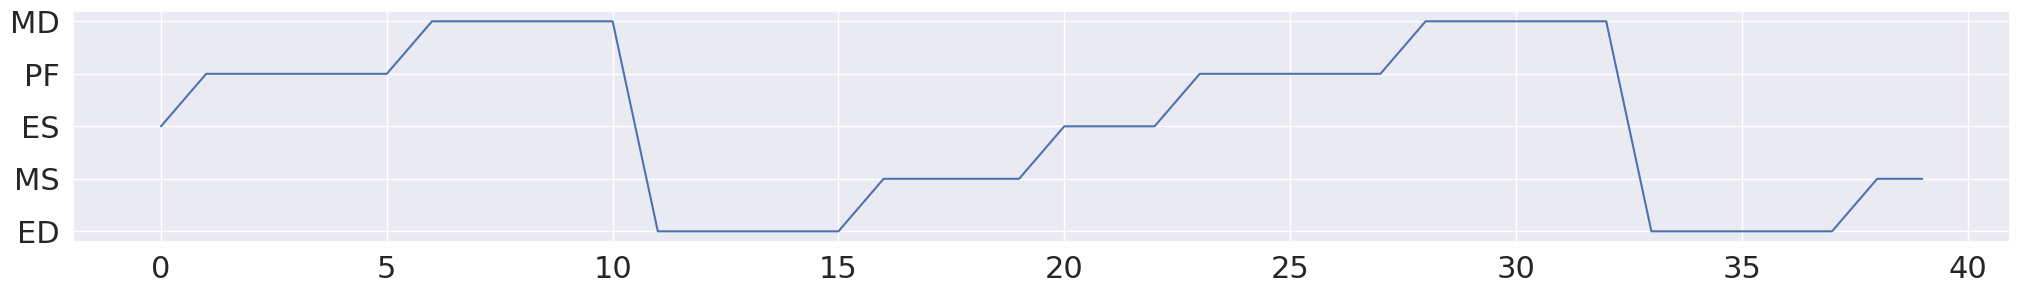

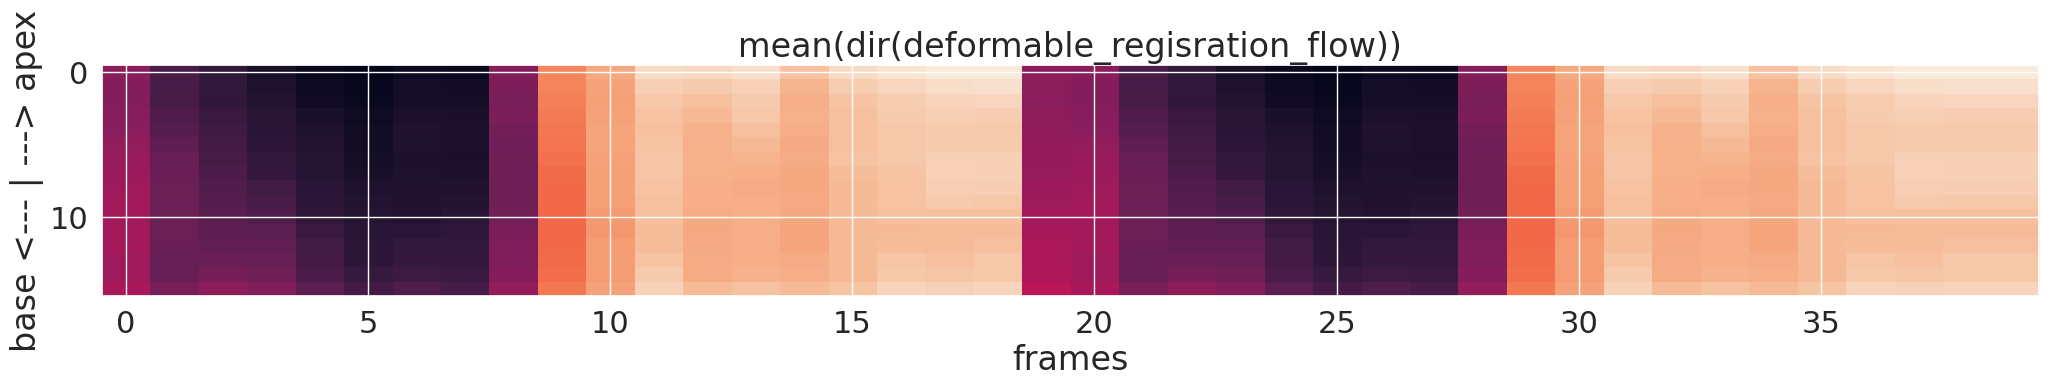

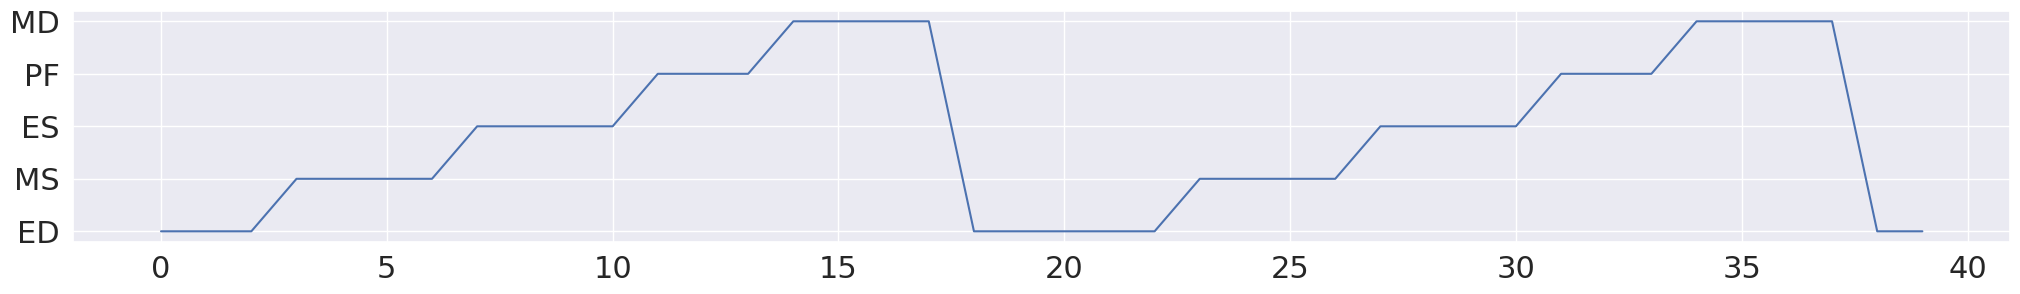

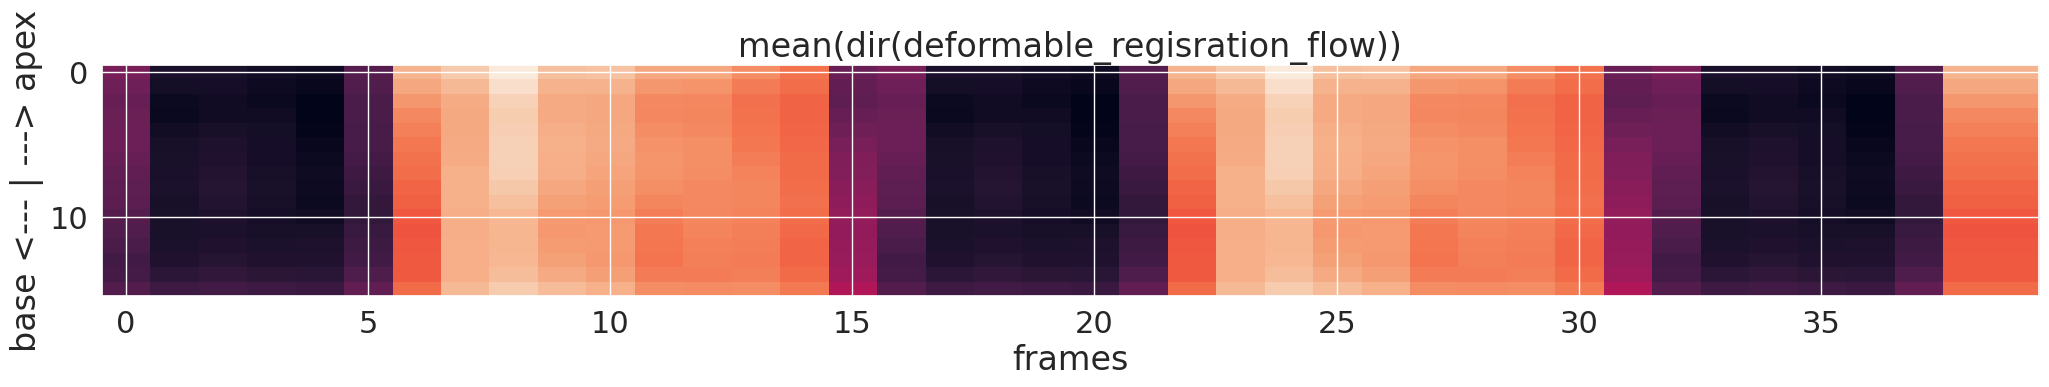

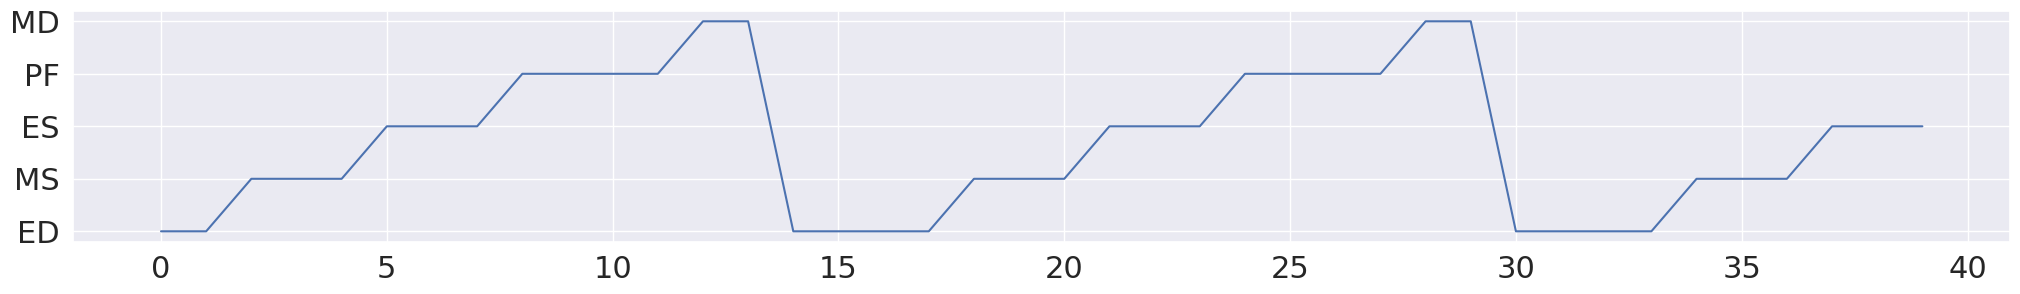

In [43]:
# plot vector direction (t x z) and the gt phases for n patientens
examples = 4
dir_axis=0
ndas = []
dim = nda_vects.shape[2:-1]
#print(dim)
idx = get_idxs_tf(dim)
c = get_centers_tf(dim)
#print('centers: ',c.shape)
centers = c - idx
centers_tensor = centers[tf.newaxis, ...]
flow2direction_lambda = tf.keras.layers.Lambda(
        lambda x: get_angle_tf(x[...,dir_axis:], centers_tensor[...,dir_axis:]), name='flow2direction')
for n in nda_vects[0:examples]:
    directions = flow2direction_lambda(n[np.newaxis,...]).numpy()[0]
    print(directions.shape)
    ndas.append(directions.mean(axis=(2,3))[...,0])
#print(ndas[0].shape)
for i in range(len(ndas)):
    fig, ax = plt.subplots(figsize=(25,3))
    n = ndas[i]
    #print(n.shape)
    _ = plt.imshow(n.T, aspect='auto')
    _ = ax.set_title('mean(dir(deformable_regisration_flow))')
    _ =ax.set_ylabel('base <--- | ---> apex')
    _ =ax.set_xlabel('frames')
    
    fix, ax = plt.subplots(figsize=(25,3))
    _ = plt.plot(np.argmax(gt[i], axis=1))
    phases = ['ED', 'MS', 'ES', 'PF', 'MD']
    _ = ax.set_yticks([0, 1, 2, 3, 4], minor=False)
    _ = ax.set_yticklabels(phases)


In [373]:
onehot = np.arange(10)
print(onehot)

[0 1 2 3 4 5 6 7 8 9]


In [ ]:
lower, upper = self.AUGMENT_PHASES_RANGE
rand = random.randint(lower, upper)
onehot = np.concatenate([onehot[rand:], onehot[:rand]], axis=0)
onehot

# 8. Inter-Observer variabillity

Compare Tariques phase-Excel-sheet with original phase for ED and ES from the ACDC dataset

In [57]:
patient_paths = sorted(glob.glob('/mnt/ssd/data/acdc/orig_save/all/*/Info.cfg'))
print(len(patient_paths))
print(patient_paths[0:5])

100
['/mnt/ssd/data/acdc/orig_save/all/patient001/Info.cfg', '/mnt/ssd/data/acdc/orig_save/all/patient002/Info.cfg', '/mnt/ssd/data/acdc/orig_save/all/patient003/Info.cfg', '/mnt/ssd/data/acdc/orig_save/all/patient004/Info.cfg', '/mnt/ssd/data/acdc/orig_save/all/patient005/Info.cfg']


In [58]:
patient_paths = [p for p in patient_paths if '090' not in p]
print(len(patient_paths))
print(patient_paths[0:5])

99
['/mnt/ssd/data/acdc/orig_save/all/patient001/Info.cfg', '/mnt/ssd/data/acdc/orig_save/all/patient002/Info.cfg', '/mnt/ssd/data/acdc/orig_save/all/patient003/Info.cfg', '/mnt/ssd/data/acdc/orig_save/all/patient004/Info.cfg', '/mnt/ssd/data/acdc/orig_save/all/patient005/Info.cfg']


In [59]:
patients = [os.path.basename(os.path.dirname(p)) for p in patient_paths]
print(len(patients))
print(patients[0:5])

99
['patient001', 'patient002', 'patient003', 'patient004', 'patient005']


In [60]:
file_4d = glob.glob(os.path.join(os.path.dirname(patient_paths[94]), '*4d.nii.gz'))
print(file_4d)
frames_total = sitk.GetArrayFromImage(sitk.ReadImage(file_4d[0])).shape[0]
print(frames_total)

['/mnt/ssd/data/acdc/orig_save/all/patient096/patient096_4d.nii.gz']
15


In [61]:
import yaml
def read_cfg_file(f):
    """Helper to open cfg files"""
    with open(f, 'r') as yml_file:
        cfg = yaml.load(yml_file, Loader=yaml.FullLoader)
    return cfg

def get_idx(cfg_f):
    patient = os.path.basename(os.path.dirname(cfg_f))
    patient_short = patient.split('patient')[1]
    cfg = read_cfg_file(cfg_f)
    file_4d = glob.glob(os.path.join(os.path.dirname(cfg_f), '*4d.nii.gz'))
    frames_total = sitk.GetArrayFromImage(sitk.ReadImage(file_4d[0])).shape[0]
    frames_total_cfg = int('{:02}'.format(cfg.get('NbFrame', 'NOPHASE')))
    if frames_total != frames_total_cfg:
        print('patient: {} total: {}, total cfg: {}'.format(patient_short, frames_total, frames_total_cfg))
    frame_ed = '{:02}'.format(cfg.get('ED', 'NOPHASE'))
    frame_es = '{:02}'.format(cfg.get('ES', 'NOPHASE'))
    return patient_short, int(frame_ed), int(frame_es), int(frames_total)

In [62]:
idxs = [get_idx(c) for c in patient_paths]

In [63]:
df = pd.DataFrame(idxs, columns=['patient', 'ED#', 'ES#', 'total'])
df

patient  ED#  ES#  total
0      001    1   12     30
1      002    1   12     30
2      003    1   15     30
3      004    1   15     28
4      005    1   13     30
..     ...  ...  ...    ...
94     096    1    8     15
95     097    1   11     30
96     098    1    9     22
97     099    1    9     19
98     100    1   13     34

[99 rows x 4 columns]

In [64]:
df_phase_file = '/mnt/ssd/data/acdc/original/SAx_3D_dicomTags_phase.csv'
df_phase = pd.read_csv(df_phase_file,dtype={'patient':str, 'ED#':int, 'MS#':int, 'ES#':int, 'PF#':int, 'MD#':int})
df_phase = df_phase[['patient', 'ED#','ES#']]
df_phase

patient  ED#  ES#
0      001   29   12
1      002   29   11
2      003   28   14
3      004    0   13
4      005   29   12
..     ...  ...  ...
94     096    0    6
95     097   28   10
96     098   21    8
97     099    0    6
98     100    1   12

[99 rows x 3 columns]

In [65]:
df_phase['total'] = df['total']
df_phase['ED_orig'] = df['ED#']
df_phase['ES_orig'] = df['ES#']

df_phase['ED_orig'] = df_phase['ED_orig'] -1
df_phase['ES_orig'] = df_phase['ES_orig'] -1
df_phase['ED_diff'] = df_phase['ED#'] == df_phase['ED_orig']
df_phase['ES_diff'] = df_phase['ES#'] == df_phase['ES_orig']

In [66]:
df_phase['ED_diff'].sum()

21

In [67]:
df_phase['ES_diff'].sum()

51

In [68]:
df_phase['ED#'][0], df_phase['ED_orig'][0], df_phase['total'][0]

(29, 0, 30)

In [69]:
import tensorflow as tf
def get_min_distance(vals):

    smaller = tf.reduce_min(vals[0:2], keepdims=True)
    bigger = tf.reduce_max(vals[0:2], keepdims=True)
    mod = vals[2]

    diff = bigger - smaller
    diff_ring = tf.math.abs(mod - bigger + smaller)# we need to use the abs to avoid 0 - 0
    min_diff = tf.reduce_min(tf.stack([diff, diff_ring]))
    tf.math.greater_equal(min_diff, 0) # this is an int, as we measure the distance between buckets for the metric
    return min_diff


ed_dist_lambda = lambda x : get_min_distance([x['ED#'], x['ED_orig'], x['total']]).numpy()
es_dist_lambda = lambda x : get_min_distance([x['ES#'], x['ES_orig'], x['total']]).numpy()

In [70]:
df_phase['ED_dist'] = df_phase.apply(ed_dist_lambda, axis=1)
df_phase['ES_dist'] = df_phase.apply(es_dist_lambda, axis=1)

In [71]:
df_phase

patient  ED#  ES#  total  ED_orig  ES_orig  ED_diff  ES_diff  ED_dist  \
0      001   29   12     30        0       11    False    False        1   
1      002   29   11     30        0       11    False     True        1   
2      003   28   14     30        0       14    False     True        2   
3      004    0   13     28        0       14     True    False        0   
4      005   29   12     30        0       12    False     True        1   
..     ...  ...  ...    ...      ...      ...      ...      ...      ...   
94     096    0    6     15        0        7     True    False        0   
95     097   28   10     30        0       10    False     True        2   
96     098   21    8     22        0        8    False     True        1   
97     099    0    6     19        0        8     True    False        0   
98     100    1   12     34        0       12    False     True        1   

    ES_dist  
0         1  
1         0  
2         0  
3         1  
4         0  
..      ...  
94        1  
95        0  
96        0  
97        2  
98        0  

[99 rows x 10 columns]

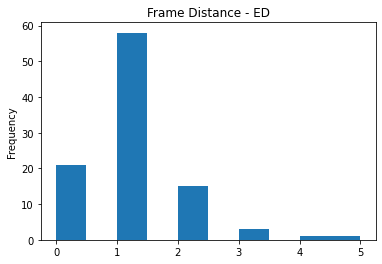

In [72]:
ax = df_phase['ED_dist'].plot(kind='hist')
_ = ax.set_title('Frame Distance - ED')

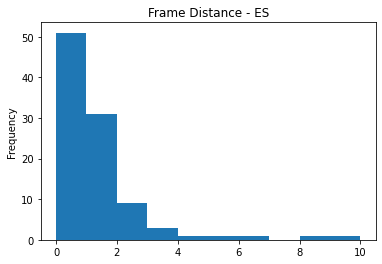

In [73]:
ax = df_phase['ES_dist'].plot(kind='hist')
_ =ax.set_title('Frame Distance - ES')

Mean ED 1.07 +/- 0.86
Mean ES 0.919 +/- 1.6


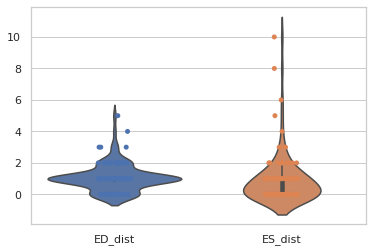

In [300]:
import seaborn as sb
sb.set_theme(style="whitegrid")
sb.violinplot(data=df_phase[['ED_dist','ES_dist']])
sb.stripplot(data=df_phase[['ED_dist','ES_dist']])
print('Mean ED {:1.3} +/- {:1.3}'.format(df_phase['ED_dist'].mean(), df_phase['ED_dist'].std()))
print('Mean ES {:1.3} +/- {:1.3}'.format(df_phase['ES_dist'].mean(), df_phase['ES_dist'].std()))

In [225]:
from ipywidgets import interact, widgets
@interact
def inspect_frame_diffs(patients='', 
                        ed_diff=(widgets.IntSlider(min=0,max=15,step=1,value=15)),
                        es_diff=(widgets.IntSlider(min=0,max=15,step=1,value=15)),
                       greater_as=False):
    temp = df_phase.copy()
    if len(patients) > 0:
        temp = df_phase[df_phase['patient'].str.contains(patients)]
    if greater_as:
        temp = temp[(temp['ED_dist']>=ed_diff) | (temp['ES_dist']>=es_diff)]
    else:
        temp = temp[(temp['ED_dist']<=ed_diff) | (temp['ES_dist']<=es_diff)]
    print(temp.shape)
    return temp

interactive(children=(Text(value='', description='patients'), IntSlider(value=15, description='ed_diff', max=1…